This code is meant to compare between the control run and the experiments when cloud-radiative interactions are turned off.

In [1]:
from wrf import getvar, ALL_TIMES
import matplotlib as mpl
import cartopy.crs as ccrs
import glob
import dask
# import cartopy.feature as cfeature
# import metpy.calc as mpcalc/
# from metpy.cbook import get_test_data
# from metpy.interpolate import cross_section
# from cartopy.io.img_tiles import Stamen
# from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from matplotlib import cm
# from datetime import datetime, timedelta
import numpy as np
import xarray as xr
import os
# from braceexpand import braceexpand
# import pandas as pd
import time
# import netCDF4 as nc
# import math
from math import cos, asin, sqrt, pi

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Set global variables
Anything that will be used throughout the script should be assigned here.

In [2]:
# Set the bounds you want to look at
lat_bound = [-5,5]			# South to North
lon_bound_d01 = [80,135]	# West to East
lon_bound_d02 = [90,125]	# West to East
lat_avg_bound = [-5,5]
d0x = 2						# number of domains

### List of various functions that are used throughout the script

In [3]:
# Calculate Temperature [K] via potential temperature equation [PT = T * (Po/P) ^ .286]
def theta_to_temp(theta):
	# PT = T * (P0/P)^(R/Cp)
		# PT = Potential temperature/theta
		# T = Temperature
		# P0 = 1000 hPa
		# P = Pressure
		# R = Gas constant for air (287.052874 J/(kg*K))
		# Cp = Specific heat capacity at constant pressure (1003.5 J/(kg*K))
			# R/Cp = 0.286
	# so
	# T = PT / (P0/P)^(0.286)
	temp = xr.zeros_like(theta)
	P = theta.bottom_top.values
	for i in range(len(P)):
		temp[:,i,...] = theta[:,i,...] / (1000/P[i])**(0.286)
	
	temp.name = 'Temperature'
	return temp

In [4]:
# Calculate Saturation Vapor Pressure 
def sat_vap_press(temperature):
	# Follow the Clausius-Clapeyron equation 
		# Link: https://geo.libretexts.org/Bookshelves/Meteorology_and_Climate_Science/Practical_Meteorology_(Stull)/04%3A_Water_Vapor/4.00%3A_Vapor_Pressure_at_Saturation
		# es = e0 * exp([L/Rv] * (1/T0 - 1/T))
	e0=6.113		# [hPa]
	Rv=461			# [J/(K*kg)]
	T0=273.15		# [K]
	Lv=2.5*(10**6)	# [J/kg]	# liquid water
	Ld=2.83*(10**6)	# [J/kg]	# ice water
	# Create matrix/dataarray da that has variable L values based on the 
		# temperature of the atmosphere where it changes based on if T < 0°C 
		# Divide by rv to create the constant L/Rv
	constant = temperature.where(temperature>273.15, Lv)/Rv
	constant = temperature.where(temperature<=273.15, Ld)/Rv

	es = e0 * np.exp(constant * ((1/T0)-(1/temperature)))

	es.name = 'Saturation Vapor Pressure'
	es = es.assign_attrs(Units='hPa')
	
	return es

In [5]:
def sat_mixing_ratio(es):
	# Calculate saturated mixing ratio
	# https://glossary.ametsoc.org/wiki/Mixing_ratio
	ws = xr.zeros_like(es)
	P = es.bottom_top.values
	for i in range(len(P)):
		ws[:,i,...] = 0.62197*((es[:,i,...])/(P[i]-es[:,i,...]))	# [kg/kg]
	
	ws.name = 'Saturation Mixing Ratio'
	ws = ws.assign_attrs(Units='kg/kg')
	
	return ws

In [6]:
def rel_hum(theta,w):
	# Calculate the relative humidity via observed potential temperature [K] and mixing ratio [kg/kg]
	temperature = theta_to_temp(theta)	# [K]
	es = sat_vap_press(temperature)		# [hPa]
	ws = sat_mixing_ratio(es)			# [kg/kg]
	RH = w/ws * 100						# [%]

	RH.name = 'Relative Humidity'
	RH = RH.assign_attrs(Units='%')

	return RH

In [7]:
# Purpose: To grab the indicies that correspond to the times, latitudes, and longitudes of the WRF dataset file.

# Input:
	# file == path to the .nc file
	# times == np.datetime64 array [Start,End]
	# lats == np.array [south,north]
	# lons == np.array [west,east]

# Output:
	# time_ind, lat_ind, lon_ind == corresponds to the indicies of the times, lats, and lons provided within that file

# Example:
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# isel_ind(file, times, lats, lons)

def isel_ind(file,times,lats,lons):
	# Declare the variables
	time_ind = np.zeros(2, dtype=int)
	lat_ind = np.zeros(2, dtype=int)
	lon_ind = np.zeros(2, dtype=int)
	# Open the file
	ds = xr.open_dataset(file)
	# Times
	time_ind[0] = np.absolute(ds.XTIME.compute().values - (times[0])).argmin()
	time_ind[1] = np.absolute(ds.XTIME.compute().values - (times[1])).argmin()+1	# + 1 is because of the way argmin works
	# Latitudes
	lat_ind[0] = np.absolute(ds.XLAT[0,:,0].compute().values-(lats[0])).argmin()
	lat_ind[1] = np.absolute(ds.XLAT[0,:,0].compute().values-(lats[1])).argmin()+1
	# Longitude
	lon_ind[0] = np.absolute(ds.XLONG[0,0,:].compute().values-(lons[0])).argmin()
	lon_ind[1] = np.absolute(ds.XLONG[0,0,:].compute().values-(lons[1])).argmin()+1

	return time_ind, lat_ind, lon_ind

In [8]:
# Purpose: Opens a dataset with restrictive bounds to make opening large files less intensive

# Input:
	# file == path to the .nc file
	# time_ind == indicies (inclusive) of the dates you want to look at
	# lat_ind == indicies (inclusive) of the latitudes you want to look at
	# lon_ind == indicies (inclusive) of the longitudes you want to look at

# Output:
	# ds == dataset that corresponds to the times, lats, and lons provided.

# Example:
	# To get the indicies, I suggest using the function isel_ind() I have coded up in tandem with this function (see above).
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# time_ind, lat_ind, lon_ind = isel_ind(file, times, lats, lons)
	# ds = open_ds(file,time_ind,lat_ind,lon_ind)

def open_ds(file,time_ind,lat_ind,lon_ind):
	# if cross==True :	# If it is a cross-section ds
	# 	ds = xr.open_dataset(file).isel(
	# 		Time=slice(time_ind[0],time_ind[1]),
	# 	)
	# else:
	ds = xr.open_dataset(file, chunks='auto').isel(
		Time=slice(time_ind[0],time_ind[1]),
		south_north=slice(lat_ind[0],lat_ind[1]),
		west_east=slice(lon_ind[0],lon_ind[1])
	)
	return ds

In [9]:
# This function finds the distance [km] between two coordinates in lat & lon
def dist(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

In [10]:
# Purpose: Rotate a vectorized variable like a wind vector in x/lon and y/lat space!
	# See Lecture02_Vector.pdf in METR 5113 Advanced Atmospheric Dynamics folder

# Input:
    # da_x  = 		xr.data_array		 	# Should be the X component of the vector
    # da_y  = 		xr.data_array			# Should be the Y component of the vector
		# Can be one time step or pressure level or even a 4-D variable [Time x Height x Lat x Lon]
    # theta =		rotation in radians		
		# Must be -pi/2 < theta < pi/2, you don't need to rotate any more than the 180° provided
		# Positive theta indiates anticlockwise turn of coordinates
		# Negative theta indiates clockwise turn of coordinates
# Output:
    # da_x_rot:		da_x but rotated
	# da_y_rot:		da_y but rotated
# Process:
    # Check if theta is positive or negative
		# Based on the value, the projections using theta will change
	# Project the current x and y coordinate to the new rotated x and y coordinates for each component.
	# Once rotated, return the rotated x and y components
# Example:
	# da_x = da_d01_U
	# da_y = da_d01_V
	# theta = pi/4	# 45° rotation anti-clockwise
	# da_d01_U_rotated, da_d01_V_rotated = rotate_vec(da_x, da_y, theta)

def rotate_vec(da_x, da_y, theta):
	# anti-clockwise rotation
	if theta > 0:
		da_x_rot = da_x*cos(theta) + da_y*cos((pi/2)-theta)
		da_y_rot = da_x*cos((pi/2)-theta) + da_y*cos(theta)
	# clockwise rotation
	if theta < 0:
		da_x_rot = da_x*cos(-theta) + da_y*cos((pi/2)+theta)
		da_y_rot = da_x*cos((pi/2)+theta) + da_y*cos(-theta)

	return da_x_rot, da_y_rot

In [11]:
# Purpose: Create an array with multiple cross-sectional data from WRFoutput.
# Input:
    # da = 			xr.data_array		 	works with both 2-D and 3-D variables!
    # start_coord = [latitude, longitude] 
    # end_coord = 	[latitude, longitude]
	# width = 		spread of cross-section in degrees i.e., 0.75° = 0.75
	# dx = 			distance between each cross-sectional line i.e., 0.05° = 0.05
# Output:
    # da_cross: 		matrix in time, height, distance, and # of lines
		# 					or time, distance, and # of lines if using a 2-D variable
	# all_line_coords:	
# Process:
	# Make sure you 'da' have assigned coordinates corresponding to south_north and west_east.
    # We first create a main line between start_coord -> end_coord. This line will be the center
		# line for all other lines to sit next to.
	# Depending on the angle of the line (more latitudinal change or longitudinal change), this
		# function will account for that and make the longest side the length of the cross-sectional line
	# We then create an empty np.array, calculate the change in spread needed, then start filling in the data.

def cross_section_multi(da, start_coord, end_coord, width, dx):

	# We want to first create a line between start and end_coords
		# Gather the indicies of the closest gridboxes of start and end_coords.
	start_ilat = int((abs((da.XLAT[0,:,0]) - (start_coord[0]))).argmin())
	end_ilat = int((abs((da.XLAT[0,:,0]) - (end_coord[0]))).argmin())
	start_ilon = int((abs((da.XLONG[0,0,:]) - (start_coord[1]))).argmin())
	end_ilon = int((abs((da.XLONG[0,0,:]) - (end_coord[1]))).argmin())
	# This statement ensures that the length of the line will be the size of the LONGEST side (either lat or lon)
	if abs(start_ilat-end_ilat)>=abs(start_ilon-end_ilon):
		line_coords = np.zeros([2,abs(start_ilat-end_ilat)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilat-end_ilat))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilat-end_ilat))
	else:
		line_coords = np.zeros([2,abs(start_ilon-end_ilon)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilon-end_ilon))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilon-end_ilon))

	##########################################################################################################################
	# Now that we have the coordinates between the start and end_coords, we need to replicate it for all the lines
	num_lines = int(width/dx)
	spread = np.arange(width/2,-width/2,-dx)
	if 'bottom_top' in da.dims:	# If the dataset is 3-D
		#						TIME	x	HEIGHT	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],da.shape[1],line_coords.shape[1],num_lines])
	else:
		#						TIME	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],line_coords.shape[1],num_lines])

	# Create all_line_coords that holds all the coordinates for every line produced
	all_line_coords = np.zeros([line_coords.shape[0],line_coords.shape[1],spread.shape[0]])

	# Looping over all the lines
	for i in range(len(spread)):
		# Now that we have our lines, we can interpolate the dataset with the offset for each line applied
		da_interp = da.interp(south_north=line_coords[0,:]+spread[i], west_east=line_coords[1,:]-spread[i], method="linear")

		# Populate the new data array with data from the cross section
			# Loop through the length of the line, find the match, and then populate it.
		if 'bottom_top' in da.dims:	# If the dataset is 3-D
			for j in range(da_cross.shape[2]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,:,j,i] = data
		else:
			for j in range(da_cross.shape[1]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,j,i] = data

		all_line_coords[0,:,i] = line_coords[0,:]+spread[i]
		all_line_coords[1,:,i] = line_coords[1,:]-spread[i]

	return da_cross, all_line_coords

In [12]:
def hov_diurnal(da, LT):
    # Average over the bounds to create shape of (time,west_east)
    da_avg = da.where((da.XLAT>lat_avg_bound[0])&(da.XLAT<lat_avg_bound[1]),drop=True).mean(dim='south_north')

    if LT:
        # Create a np.array with shape (west_east,hour). Then populate each longitude column with its respective
            # diurnal cycle of rain rate.
        array = np.zeros((da_avg.shape[1],24))
        # Loop through each longitude, look through all the timesteps and group them by hour,
            # and then average the values at each hour. Output the 1x24 array into the empty array
        for i in range(array.shape[0]):
            array[i,:] = da_avg[:,i].groupby('LocalTime.hour').mean()
    else:
        array = da_avg.mean('west_east').groupby('XTIME.hour').mean()
    return array

In [13]:
# Purpose: To alliviate the memory issue that arrises when you getvar() a big dataset.
# Input:
    # xrDataset = xr.open_dataset(filepath)
    # Dataset = Dataset(filepath)
    # varname = '<variablename>'
# Output:
    # da: This will be the xr.DataArray you are after
# Process:
    # First create an empty np.array that holds varname values.
    # Loop through each timestep to fill in the np.array.
    # Here's the trick, only getvar() one timestep, then expand the time dim.
        # This will repeate the values from the first timestep into the Time dim.
    # Assign the Time coordinates.
    # Replace the repeated values with the correct values from npArray.

# This method is ~6x more efficient than getvar(Dataset, varname, ALL_TIMES)

def wrf_np2da(xrDataset,Dataset,varname):
    da_times = getvar(Dataset, 'times', ALL_TIMES)			# Times in datetime64
    # Create empty numpy array
    npArray = np.empty((xrDataset.dims['Time'],xrDataset.dims['bottom_top'],
                        xrDataset.dims['south_north'],xrDataset.dims['west_east']),np.float32)
    for i in range(npArray.shape[0]):
        npArray[i,...] = getvar(Dataset, varname, timeidx=i, meta=False)
    da = getvar(Dataset, varname, timeidx=0)
    da = da.expand_dims(dim={'Time': da_times}, axis=0)
    da = da.assign_coords(dict(
        Time=('Time',da_times.values),
        XTIME=('Time',np.float32(xrDataset['ITIMESTEP'].values))
    ))
    da.values = npArray
    return da

In [14]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.

def assign_LT_coord(da):
	hour_offset = (da.XLONG.values[:,0,:]/15).round(decimals=0)
	local_time = np.empty([len(da.Time),len(da.west_east)], dtype=object)
	for i in range(local_time.shape[0]):
		for j in range(local_time.shape[1]):
			local_time[i,j] = da.XTIME.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
	da = da.assign_coords(LocalTime=(('Time','west_east'),local_time))
	return da

## Read in variables


### Control Data
This section opens stitched wrfout .nc files. The raw .nc file is much to large, so I have extracted variables from the large file into smaller .nc files that only contains one variable. To get these smaller .nc files, please refer to extract_variable.py and interp_variable.py function I have created. This section opens those files up and assigned them to a variable.

Temporal 10.5-day (2015 11-22-12UTC -> 2015 12-03-00UTC)

Below the section where I assigned file names, there is an option for you to only open up a smaller domain (spatial and temporal) if you are interetsed in a select region. This will save you a lot of computational time.

In [32]:
start_time = time.perf_counter()

parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00'
# parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/CRFoff/MC_Sumatra_2015-11-25--26/2015-11-25-03--11-26-12'
file_d01_raw = parent_dir + '/raw/d01'
file_d02_raw = parent_dir + '/raw/d02'
# 2-D data
file_d01_RR = parent_dir + '/L1/d01_RR'				# [mm/dt]
file_d02_RR = parent_dir + '/L1/d02_RR'				# [mm/dt]
file_d01_PSFC = parent_dir + '/L1/d01_PSFC'		    # [hPa]
file_d02_PSFC = parent_dir + '/L1/d02_PSFC'		    # [hPa]
file_d01_T2 = parent_dir + '/L1/d01_T2'		        # [K]
file_d02_T2 = parent_dir + '/L1/d02_T2'		        # [K]
file_d01_U10 = parent_dir + '/L1/d01_U10'		    # [m/s]
file_d02_U10 = parent_dir + '/L1/d02_U10'		    # [m/s]
file_d01_V10 = parent_dir + '/L1/d01_V10'		    # [m/s]
file_d02_V10 = parent_dir + '/L1/d02_V10'		    # [m/s]
# Raw data
file_d01_P = parent_dir + '/L1/d01_P'				# [mm/dt]
file_d02_P = parent_dir + '/L1/d02_P'				# [mm/dt]
# Interpolated data 
file_d01_U = parent_dir + '/L2/d01_interp_U'	        # [m/s]
file_d02_U = parent_dir + '/L2/d02_interp_U'	        # [m/s]
file_d01_V = parent_dir + '/L2/d01_interp_V'	        # [m/s]
file_d02_V = parent_dir + '/L2/d02_interp_V'	        # [m/s]
file_d01_QV = parent_dir + '/L2/d01_interp_QV'	        # [kg/kg]
file_d02_QV = parent_dir + '/L2/d02_interp_QV'	        # [kg/kg]
file_d01_CLDFRA = parent_dir + '/L2/d01_interp_CLDFRA'	# 
file_d02_CLDFRA = parent_dir + '/L2/d02_interp_CLDFRA'	# 
file_d01_LH = parent_dir + '/L2/d01_interp_LH'	        # [K/s]
file_d02_LH = parent_dir + '/L2/d02_interp_LH'	        # [K/s]
file_d01_LWAll = parent_dir + '/L2/d01_interp_LWAll'	# [K/s]
file_d02_LWAll = parent_dir + '/L2/d02_interp_LWAll'	# [K/s]
file_d01_LWClear = parent_dir + '/L2/d01_interp_LWClear'# [K/s]
file_d02_LWClear = parent_dir + '/L2/d02_interp_LWClear'# [K/s]
file_d01_SWAll = parent_dir + '/L2/d01_interp_SWAll'	# [K/s]
file_d02_SWAll = parent_dir + '/L2/d02_interp_SWAll'	# [K/s]
file_d01_SWClear = parent_dir + '/L2/d01_interp_SWClear'# [K/s]
file_d02_SWClear = parent_dir + '/L2/d02_interp_SWClear'# [K/s]
file_d01_Theta = parent_dir + '/L2/d01_interp_Theta'	# [K]
file_d02_Theta = parent_dir + '/L2/d02_interp_Theta'	# [K]
    # At single hPa levels
# file_d01_QV850 = parent_dir + '/L2/d01_interp_QV850'	# [kg/kg]
# file_d02_QV850 = parent_dir + '/L2/d02_interp_QV850'	# [kg/kg]
# file_d01_U850 = parent_dir + '/L2/d01_interp_U850'	# [m/s]
# file_d02_U850 = parent_dir + '/L2/d02_interp_U850'	# [m/s]
# file_d01_U200 = parent_dir + '/L2/d01_interp_U200'	# [m/s]
# file_d02_U200 = parent_dir + '/L2/d02_interp_U200'	# [m/s]

######################################################################################
################ Declare the bounds you want to specifically look at #################
#### All the data 
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-02T12')]
# lats = [-20, 20]
# lons = [80, 135]

#### Some of the data
times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-12-03T00')]
# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
# times = [np.datetime64('2015-11-25T00'), np.datetime64('2015-11-26T12')]
lats = [-7.5, 7.5]
lons = [90, 110]
######################################################################################
# Setup the indicies that will be used throughout
time_ind_d01, lat_ind_d01, lon_ind_d01 = isel_ind(file_d01_raw, times, lats, lons)
time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(file_d02_raw, times, lats, lons)

# Raw datasets
ds_d01 = open_ds(file_d01_raw,time_ind_d01,lat_ind_d01,lon_ind_d01)
ds_d02 = open_ds(file_d02_raw,time_ind_d02,lat_ind_d02,lon_ind_d02)
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')


# Coordinate dictionaries:
step2_time = time.perf_counter()
interp_P_levels = np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50)))

interp_P_levels_d01 = np.resize(interp_P_levels,(ds_d01.XLAT.shape[2],ds_d01.XLAT.shape[1],len(interp_P_levels)))
interp_P_levels_d01 = np.swapaxes(interp_P_levels_d01, 0, 2)
d01_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d01.XTIME.values),
    south_north=(('south_north'),ds_d01.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d01.XLONG[0,0,:].values)
    )
interp_P_levels_d02 = np.resize(interp_P_levels,(ds_d02.XLAT.shape[2],ds_d02.XLAT.shape[1],len(interp_P_levels)))
interp_P_levels_d02 = np.swapaxes(interp_P_levels_d02, 0, 2)
d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d02.XTIME.values),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )

# Function that can removes the bottom_top dimension for 2-D datasets
def without_keys(d, keys):
	return {x: d[x] for x in d if x not in keys}
step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')


###########################################################
################# Load in the variables ###################
###########################################################


##################### 3-D variables #######################

# ############ Interpolated zonal winds   [m/s] #############
# step2_time = time.perf_counter()
# # d01   # how I used to open data: ds = xr.open_dataset(file_d01_U).isel(Time=slice(0,t))
# ds = open_ds(file_d01_U,time_ind_d01,lat_ind_d01,lon_ind_d01)

# da_d01_U = ds['U'].compute()
# da_d01_U = da_d01_U.assign_coords(d01_coords)
# fill_value_f8 = da_d01_U.max()      # This is the fill_value meaning missing_data
# da_d01_U = da_d01_U.where(da_d01_U!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_U,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_U = ds['U'].compute()
# da_d02_U = da_d02_U.assign_coords(d02_coords)
# # fill_value = da_d02_U.max()      # This is the fill_value meaning missing_data
# da_d02_U = da_d02_U.where(da_d02_U!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated zonal winds loaded \N{check mark}', step1_time-step2_time, 'seconds')


# ############ Interpolated Meridional winds   [m/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_V,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_V = ds['V'].compute()
# da_d01_V = da_d01_V.assign_coords(d01_coords)
# # fill_value = da_d01_V.max()      # This is the fill_value meaning missing_data
# da_d01_V = da_d01_V.where(da_d01_V!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_V,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_V = ds['V'].compute()
# da_d02_V = da_d02_V.assign_coords(d02_coords)
# # fill_value = da_d02_V.max()      # This is the fill_value meaning missing_data
# da_d02_V = da_d02_V.where(da_d02_V!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated meridional winds loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Interpolated water vapor mixing ratio  [kg/kg] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_QV,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_QV = ds['QV'].compute()
# da_d01_QV = da_d01_QV.assign_coords(d01_coords)
# da_d01_QV = da_d01_QV.where(da_d01_QV!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_QV,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_QV = ds['QV'].compute()
# da_d02_QV = da_d02_QV.assign_coords(d02_coords)
# da_d02_QV = da_d02_QV.where(da_d02_QV!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Interpolated water vapor mixing ratio loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud Fraction [0-1] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_CLDFRA,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_CLDFRA = ds['CLDFRA'].compute()
# da_d01_CLDFRA = da_d01_CLDFRA.assign_coords(d01_coords)
# da_d01_CLDFRA = da_d01_CLDFRA.where(da_d01_CLDFRA!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_CLDFRA,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_CLDFRA = ds['CLDFRA'].compute()
# da_d02_CLDFRA = da_d02_CLDFRA.assign_coords(d02_coords)
# da_d02_CLDFRA = da_d02_CLDFRA.where(da_d02_CLDFRA!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Cloud fraction loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Latent Heating [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LH,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LH = ds['LH'].compute()
# da_d01_LH = da_d01_LH.assign_coords(d01_coords)
# da_d01_LH = da_d01_LH.where(da_d01_LH!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LH,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LH = ds['LH'].compute()
# da_d02_LH = da_d02_LH.assign_coords(d02_coords)
# da_d02_LH = da_d02_LH.where(da_d02_LH!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Latent heating loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Potential Temperature [K] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_Theta,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_Theta = ds['Theta'].compute()
# da_d01_Theta = da_d01_Theta.assign_coords(d01_coords)
# da_d01_Theta = da_d01_Theta.where(da_d01_Theta!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_Theta,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_Theta = ds['Theta'].compute()
# da_d02_Theta = da_d02_Theta.assign_coords(d02_coords)
# da_d02_Theta = da_d02_Theta.where(da_d02_Theta!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWAll = ds['LWAll'].compute()
# da_d01_LWAll = da_d01_LWAll.assign_coords(d01_coords)
# da_d01_LWAll = da_d01_LWAll.where(da_d01_LWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWAll = ds['LWAll'].compute()
# da_d02_LWAll = da_d02_LWAll.assign_coords(d02_coords)
# da_d02_LWAll = da_d02_LWAll.where(da_d02_LWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Longwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_LWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_LWClear = ds['LWClear'].compute()
# da_d01_LWClear = da_d01_LWClear.assign_coords(d01_coords)
# da_d01_LWClear = da_d01_LWClear.where(da_d01_LWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_LWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_LWClear = ds['LWClear'].compute()
# da_d02_LWClear = da_d02_LWClear.assign_coords(d02_coords)
# da_d02_LWClear = da_d02_LWClear.where(da_d02_LWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Longwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating All-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWAll,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWAll = ds['SWAll'].compute()
# da_d01_SWAll = da_d01_SWAll.assign_coords(d01_coords)
# da_d01_SWAll = da_d01_SWAll.where(da_d01_SWAll!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWAll,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWAll = ds['SWAll'].compute()
# da_d02_SWAll = da_d02_SWAll.assign_coords(d02_coords)
# da_d02_SWAll = da_d02_SWAll.where(da_d02_SWAll!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave All-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Shortwave Radiative Heating Clear-Sky [K/s] ############
# step2_time = time.perf_counter()
# # d01
# ds = open_ds(file_d01_SWClear,time_ind_d01,lat_ind_d01,lon_ind_d01)
# da_d01_SWClear = ds['SWClear'].compute()
# da_d01_SWClear = da_d01_SWClear.assign_coords(d01_coords)
# da_d01_SWClear = da_d01_SWClear.where(da_d01_SWClear!=fill_value_f8)    # Change fill_value points to nans
# # d02
# ds = open_ds(file_d02_SWClear,time_ind_d02,lat_ind_d02,lon_ind_d02)
# da_d02_SWClear = ds['SWClear'].compute()
# da_d02_SWClear = da_d02_SWClear.assign_coords(d02_coords)
# da_d02_SWClear = da_d02_SWClear.where(da_d02_SWClear!=fill_value_f8)    # Change fill_value points to nans

# step1_time = time.perf_counter()
# print('Shortwave Clear-sky loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Cloud-Radiative Forcing Calculations ############
# # Longwave
# da_d01_LWCRF = da_d01_LWAll - da_d01_LWClear
# da_d02_LWCRF = da_d02_LWAll - da_d02_LWClear
# # Shortwave
# da_d01_SWCRF = da_d01_SWAll - da_d01_SWClear
# da_d02_SWCRF = da_d02_SWAll - da_d02_SWClear
# # Total
# da_d01_TotalCRF = da_d01_LWCRF + da_d01_SWCRF
# da_d02_TotalCRF = da_d02_LWCRF + da_d02_SWCRF

##################### 2-D variables #######################

############ Rain Rate     [mm/hr] ############
step2_time = time.perf_counter()
# d01
ds = open_ds(file_d01_RR,time_ind_d01,lat_ind_d01,lon_ind_d01)
da_d01_RR = ds['RR'].compute()
da_d01_RR = da_d01_RR.assign_coords(without_keys(d01_coords,'bottom_top'))
# d02
ds = open_ds(file_d02_RR,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_RR = ds['RR'].compute()
da_d02_RR = da_d02_RR.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Rain rates loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Surface Pressure     [hPa] ############
step2_time = time.perf_counter()
# d01
ds = open_ds(file_d01_PSFC,time_ind_d01,lat_ind_d01,lon_ind_d01)
da_d01_PSFC = ds['PSFC'].compute()
da_d01_PSFC = da_d01_PSFC.assign_coords(without_keys(d01_coords,'bottom_top'))
# d02
ds = open_ds(file_d02_PSFC,time_ind_d02,lat_ind_d02,lon_ind_d02)
da_d02_PSFC = ds['PSFC'].compute()
da_d02_PSFC = da_d02_PSFC.assign_coords(without_keys(d02_coords,'bottom_top'))

step1_time = time.perf_counter()
print('Surface Pressure loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Detection of land & water  ############
step2_time = time.perf_counter()
# d01
da_d01_LANDMASK = ds_d01['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0
# d02
da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()   # Land = 1, Water = 0

step1_time = time.perf_counter()
print('Landmask loaded \N{check mark}', step1_time-step2_time, 'seconds')

############ Terrain Height    [m]  ############
step2_time = time.perf_counter()
# d01
da_d01_TOPO = ds_d01['HGT'].sel(Time=slice(1)).compute().squeeze()
# d02
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()

step1_time = time.perf_counter()
print('Terrain Height loaded \N{check mark}', step1_time-step2_time, 'seconds')

# ############ Temporal and Spatial variables ############
# step2_time = time.perf_counter()
# da_d01_LATS, da_d01_LONGS = wrf.latlon_coords(da_d01_LANDMASK)	# Lat & Lon [degrees]
# da_d02_LATS, da_d02_LONGS = wrf.latlon_coords(da_d02_LANDMASK)	# Lat & Lon [degrees]
# step1_time = time.perf_counter()
# print('Tempospatial variables loaded \N{check mark}', step1_time-step2_time, 'seconds')

print('Domain d01 & d02 \N{check mark}', step1_time-start_time, 'seconds')

Dataset loaded ✓ 1.602516470476985 seconds
Created coordinate dictionaries ✓ 4.938242992386222 seconds
Rain rates loaded ✓ 10.915539463981986 seconds
Surface Pressure loaded ✓ 9.789260178804398 seconds
Landmask loaded ✓ 0.24623004905879498 seconds
Terrain Height loaded ✓ 0.47662836499512196 seconds
Domain d01 & d02 ✓ 27.9689685087651 seconds


Load in Control Data

In [33]:
# cd into the directory with your cross-sectional datasets to make the file paths when using xr.open_dataset a lot shorter
os.chdir('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/L3')

# Set the parameters for the specific island
    # Sumatra
start_coord		= [-1.8,103.8]
end_coord 		= [-5.8,99.8]
width			= 1.5
dx 				= 0.025
theta           = pi/4
## Load in the variables
start_time = time.perf_counter()
# Normal Wind [m/s]
da_d02_cross_NormalWind_cntl= xr.open_dataset('d02_cross_NormalWind')['NormalWind'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Rain Rate [mm/day]]
da_d02_cross_RR_cntl= xr.open_dataset('d02_cross_RR')['RR'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Water vapor [kg/kg]
da_d02_cross_QV_cntl= xr.open_dataset('d02_cross_QV')['QV'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Cloud water [kg/kg]
da_d02_cross_QC_cntl= xr.open_dataset('d02_cross_QC')['QC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Rain water [kg/kg]
da_d02_cross_QR_cntl= xr.open_dataset('d02_cross_QR')['QR'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Ice water [kg/kg]
da_d02_cross_QI_cntl= xr.open_dataset('d02_cross_QI')['QI'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Snow water [kg/kg]
da_d02_cross_QS_cntl= xr.open_dataset('d02_cross_QS')['QS'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Graupel water [kg/kg]
da_d02_cross_QG_cntl= xr.open_dataset('d02_cross_QG')['QG'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Total water [kg/kg]
da_d02_cross_QTotal_cntl= da_d02_cross_QV_cntl+da_d02_cross_QC_cntl+da_d02_cross_QR_cntl+da_d02_cross_QI_cntl+da_d02_cross_QS_cntl+da_d02_cross_QG_cntl
# Cloud Fraction [0->1]
da_d02_cross_CLDFRA_cntl= xr.open_dataset('d02_cross_CLDFRA')['CLDFRA'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Latent Heating [K/s]
da_d02_cross_LH_cntl= xr.open_dataset('d02_cross_LH')['LH'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Potential Temperature [K]
da_d02_cross_Theta_cntl= xr.open_dataset('d02_cross_Theta')['Theta'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# # Relative Humidity [%]
# da_d02_cross_RH_cntl = rel_hum(da_d02_cross_Theta_cntl, da_d02_cross_QTotal_cntl)
## Vertically-resolved Radiative heating
# Longwave All-sky Heating [K/s]
da_d02_cross_LWAll_cntl= xr.open_dataset('d02_cross_LWAll')['LWAll'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave Clear-sky Heating [K/s]
da_d02_cross_LWClear_cntl= xr.open_dataset('d02_cross_LWClear')['LWClear'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave CRF [K/s]
da_d02_cross_LWCRF_cntl= xr.open_dataset('d02_cross_LWCRF')['LWCRF'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave All-sky Heating [K/s]
da_d02_cross_SWAll_cntl= xr.open_dataset('d02_cross_SWAll')['SWAll'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Clear-sky Heating [K/s]
da_d02_cross_SWClear_cntl= xr.open_dataset('d02_cross_SWClear')['SWClear'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave CRF [K/s]
da_d02_cross_SWCRF_cntl= xr.open_dataset('d02_cross_SWCRF')['SWCRF'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Total CRF [K/s]
da_d02_cross_NetCRF_cntl= xr.open_dataset('d02_cross_TotalCRF')['TotalCRF'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
## Vertically-integrated Radiative heating
# Longwave Downwelling at Surface [W/m^2]
da_d02_cross_LWDownSfc_cntl= xr.open_dataset('d02_cross_LWDNB')['LWDNB'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave Downwelling at Surface, Clear-sky [W/m^2]
da_d02_cross_LWDownSfcClear_cntl= xr.open_dataset('d02_cross_LWDNBC')['LWDNBC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave Downwelling at Surface [W/m^2]
da_d02_cross_LWUpSfc_cntl= xr.open_dataset('d02_cross_LWUPB')['LWUPB'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave Downwelling at Surface, Clear-sky [W/m^2]
da_d02_cross_LWUpSfcClear_cntl= xr.open_dataset('d02_cross_LWUPBC')['LWUPBC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave Downwelling at Toa [W/m^2]
da_d02_cross_LWDownToa_cntl= xr.open_dataset('d02_cross_LWDNT')['LWDNT'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave Downwelling at Toa, Clear-sky [W/m^2]
da_d02_cross_LWDownToaClear_cntl= xr.open_dataset('d02_cross_LWDNTC')['LWDNTC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave Downwelling at Toa [W/m^2]
da_d02_cross_LWUpToa_cntl= xr.open_dataset('d02_cross_LWUPT')['LWUPT'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Longwave Downwelling at Toa, Clear-sky [W/m^2]
da_d02_cross_LWUpToaClear_cntl= xr.open_dataset('d02_cross_LWUPTC')['LWUPTC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Downwelling at Surface [W/m^2]
da_d02_cross_SWDownSfc_cntl= xr.open_dataset('d02_cross_SWDNB')['SWDNB'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Downwelling at Surface, Clear-sky [W/m^2]
da_d02_cross_SWDownSfcClear_cntl= xr.open_dataset('d02_cross_SWDNBC')['SWDNBC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Downwelling at Surface [W/m^2]
da_d02_cross_SWUpSfc_cntl= xr.open_dataset('d02_cross_SWUPB')['SWUPB'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Downwelling at Surface, Clear-sky [W/m^2]
da_d02_cross_SWUpSfcClear_cntl= xr.open_dataset('d02_cross_SWUPBC')['SWUPBC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Downwelling at Toa [W/m^2]
da_d02_cross_SWDownToa_cntl= xr.open_dataset('d02_cross_SWDNT')['SWDNT'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Downwelling at Toa, Clear-sky [W/m^2]
da_d02_cross_SWDownToaClear_cntl= xr.open_dataset('d02_cross_SWDNTC')['SWDNTC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Downwelling at Toa [W/m^2]
da_d02_cross_SWUpToa_cntl= xr.open_dataset('d02_cross_SWUPT')['SWUPT'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
# Shortwave Downwelling at Toa, Clear-sky [W/m^2]
da_d02_cross_SWUpToaClear_cntl= xr.open_dataset('d02_cross_SWUPTC')['SWUPTC'].isel(Time=slice(time_ind_d01[0],time_ind_d01[1])).compute()
## Integrated Atmospheric Cloud-radiative Forcing Calculations [W/m^2]
# Longwave Atmospheric Radiative Heating [W/m^2]
da_d02_cross_LWAtm_cntl= (da_d02_cross_LWDownToa_cntl-da_d02_cross_LWUpToa_cntl) + (da_d02_cross_LWUpSfc_cntl-da_d02_cross_LWDownSfc_cntl)
# Longwave Atmospheric Radiative Heating, Clear-sky [W/m^2]
da_d02_cross_LWAtmClear_cntl= (da_d02_cross_LWDownToaClear_cntl-da_d02_cross_LWUpToaClear_cntl) + (da_d02_cross_LWUpSfcClear_cntl-da_d02_cross_LWDownSfcClear_cntl)
# Shortwave Atmospheric Radiative Heating [W/m^2]
da_d02_cross_SWAtm_cntl= (da_d02_cross_SWDownToa_cntl-da_d02_cross_SWUpToa_cntl) + (da_d02_cross_SWUpSfc_cntl-da_d02_cross_SWDownSfc_cntl)
# Shortwave Atmospheric Radiative Heating, Clear-sky [W/m^2]
da_d02_cross_SWAtmClear_cntl= (da_d02_cross_SWDownToaClear_cntl-da_d02_cross_SWUpToaClear_cntl) + (da_d02_cross_SWUpSfcClear_cntl-da_d02_cross_SWDownSfcClear_cntl)
# Net Atmospheric Radiative Heating [W/m^2]
da_d02_cross_NetAtm_cntl= da_d02_cross_LWAtm_cntl + da_d02_cross_SWAtm_cntl
# Net Atmospheric Radiative Heating, Clear-sky [W/m^2]
da_d02_cross_NetAtmClear_cntl= da_d02_cross_LWAtmClear_cntl + da_d02_cross_SWAtmClear_cntl
# Net Atmospheric Cloud-Radiative Forcing [W/m^2]
da_d02_cross_NetAtmCRF_cntl= da_d02_cross_NetAtm_cntl - da_d02_cross_NetAtmClear_cntl

# # If first time calculating the Integrated Atmospheric values, run the section of code below
# da_d02_cross_QTotal_cntl.name = 'QTotal'
# da_d02_cross_QTotal_cntl.to_netcdf(path='d02_cross_QTotal', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_LWAtm_cntl.name = 'LWAtm'
# da_d02_cross_LWAtm_cntl.to_netcdf(path='d02_cross_LWAtm', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_LWAtmClear_cntl.name = 'LWAtmClear'
# da_d02_cross_LWAtmClear_cntl.to_netcdf(path='d02_cross_LWAtmClear', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_SWAtm_cntl.name = 'SWAtm'
# da_d02_cross_SWAtm_cntl.to_netcdf(path='d02_cross_SWAtm', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_SWAtmClear_cntl.name = 'SWAtmClear'
# da_d02_cross_SWAtmClear_cntl.to_netcdf(path='d02_cross_SWAtmClear', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_NetAtm_cntl.name = 'NetAtm'
# da_d02_cross_NetAtm_cntl.to_netcdf(path='d02_cross_NetAtm', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_NetAtmClear_cntl.name = 'NetAtmClear'
# da_d02_cross_NetAtmClear_cntl.to_netcdf(path='d02_cross_NetAtmClear', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
# da_d02_cross_NetAtmCRF_cntl.name = 'NetAtmCRF'
# da_d02_cross_NetAtmCRF_cntl.to_netcdf(path='d02_cross_NetAtmCRF', mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

step1_time = time.perf_counter()
print('Control cross-section data loaded \N{check mark}', step1_time-start_time, 'seconds')

# Terrain	Takes about 3 min
# Updated method on plotting terrain
	# I take each line from the cross section, capture the surface pressure at each line,
	# and then average it over all the lines to get the AVERAGE TERRAIN HEIGHT.)
terrain_height_d02 = np.zeros([da_d02_cross_NormalWind_cntl.shape[0],da_d02_cross_NormalWind_cntl.shape[2],da_d02_cross_NormalWind_cntl.shape[3]])
for i in range(int(len(da_d02_cross_NormalWind_cntl.Spread))):
	for j in range(da_d02_cross_NormalWind_cntl.shape[0]):
		terrain_height_d02[j,:,i] = da_d02_PSFC[j,...].interp(south_north=da_d02_cross_NormalWind_cntl.Lat[:,i], west_east=da_d02_cross_NormalWind_cntl.Lon[:,i], method="linear")
step2_time = time.perf_counter()
print('Terrain data loaded \N{check mark}', step2_time-step1_time, 'seconds')

Control cross-section data loaded ✓ 44.89653884060681 seconds
Terrain data loaded ✓ 182.82529561966658 seconds


#### Combine cross-sectional ensemble data and save them as .nc files

In [ ]:
def save_ens_cross_data(parent_dir,var_list,num_sims,sim_time_length):
	for i in var_list:		# Loop through the variables

		# Create the pathname based on the variable, then save the ensemble cross-sectional data as an .nc file
		file_names = sorted(glob.glob(parent_dir + '/2015*/L3/Sumatra_mid_central/d02_cross_' + i))

		# Open the multiple files, and concat them over the Time dimension
		da = xr.open_mfdataset(file_names, concat_dim='Time', combine='nested', data_vars='all', coords='all')[i]	# Only grab the variable from var_list

		# Is data 3-D or 2-D?
		if 'bottom_top' in da.dims:		# If the dataset is 3-D
			# Use numpy to reshape the data into dimensions of [num_sims X time X height X line_length X #_of_lines]
				# This is needed since da Time dimension is the length of each simulation * num_sims
			da_np = np.reshape(da.values, (num_sims, sim_time_length, len(da.bottom_top), len(da.Distance), len(da.Spread)))
			# Create a new dataArray that holds da_np
			da = xr.DataArray(
				name=i,
				data=da_np,
				dims=['Lead','Time','bottom_top','Distance','Spread'],
				coords=dict(
					Lead = np.arange(0,num_sims,1),
					EnsTime = (['Lead','Time'], da.Time.values.reshape(num_sims,sim_time_length)),
					bottom_top = da.bottom_top.values,
					Distance = da.Distance.values,
					Spread = da.Spread.values,
					Lat = (['Time','Distance','Spread'], da.Lat.values[:sim_time_length,:,:]),
					Lon = (['Time','Distance','Spread'], da.Lon.values[:sim_time_length,:,:])
					)
			)
			# Transpose to the way you want the dims to be ordered
			da = da.transpose('Time','bottom_top','Distance','Spread','Lead')

		else:	# If the dataset is 2-D
			# Use numpy to reshape the data into dimensions of [num_sims X time X line_length X #_of_lines]
				# This is needed since da Time dimension is the length of each simulation * num_sims
			da_np = np.reshape(da.values, (num_sims, sim_time_length, len(da.Distance), len(da.Spread)))
			# Create a new dataArray that holds da_np
			da = xr.DataArray(
				name=i,
				data=da_np,
				dims=['Lead','Time','Distance','Spread'],
				coords=dict(
					Lead = np.arange(0,num_sims,1),
					EnsTime = (['Lead','Time'], da.Time.values.reshape(num_sims,sim_time_length)),
					Distance = da.Distance.values,
					Spread = da.Spread.values,
					Lat = (['Time','Distance','Spread'], da.Lat.values[:sim_time_length,:,:]),
					Lon = (['Time','Distance','Spread'], da.Lon.values[:sim_time_length,:,:])
					)
			)
			# Transpose to the way you want the dims to be ordered
			da = da.transpose('Time','Distance','Spread','Lead')
		# Where you'd like to save the dataset as an .nc file
		path_name = parent_dir + '/Sumatra_mid_central/d02_cross_' + i + '_CRFoff'
		da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
		print(i + ' has been saved.')
	return

# Directory where all the simulation sub-directories are kept
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff'
# List of variables that you would like saved
var_list = ['NormalWind', 'CLDFRA', 'LH', 'Theta', 'QV', 'QC', 'QR', 'QI', 'QS', 'QG', 'LWAll', 'SWAll', 'RR', 'LWDNB', 'LWUPB', 'LWDNT', 'LWUPT', 'SWDNB', 'SWUPB', 'SWDNT', 'SWUPT']
num_sims = 18			# How many sims
sim_time_length = 36	# How many time steps each sim (all sims should have the same time length)

save_ens_cross_data(parent_dir,var_list,num_sims,sim_time_length)

################################################################
################ Save the rest of the variables ################
################################################################

# Calculate cross-sectional data and save them as .nc files
	# QTotal, LWAtm, LWAtmClear, SWAtm, SWAtmClear, NetAtm, NetAtmClear, NetAtmCRF
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff/Sumatra_mid_central' 

## QTotal ##
file_names = sorted(glob.glob(parent_dir + '/d02_cross_Q*'))
# Sum all the Q's
da = xr.open_dataset(file_names[0])['QC'] + xr.open_dataset(file_names[1])['QG'] + xr.open_dataset(file_names[2])['QI'] + xr.open_dataset(file_names[3])['QR'] + xr.open_dataset(file_names[4])['QS'] + xr.open_dataset(file_names[5])['QV']
da.name = 'QTotal'
# Save the file
path_name = parent_dir + '/d02_cross_QTotal_CRFoff'
da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

# No need to calculate Clear values and CRF because icloud=0 so values are already Clear
## LWAtm ##
da = (xr.open_dataset(parent_dir+'/d02_cross_LWDNT_CRFoff')['LWDNT']-xr.open_dataset(parent_dir+'/d02_cross_LWUPT_CRFoff')['LWUPT']) + (xr.open_dataset(parent_dir+'/d02_cross_LWUPB_CRFoff')['LWUPB']-xr.open_dataset(parent_dir+'/d02_cross_LWDNB_CRFoff')['LWDNB'])
da.name = 'LWAtm'
path_name = parent_dir + '/d02_cross_LWAtm_CRFoff'
da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

## SWAtm ##
da = (xr.open_dataset(parent_dir+'/d02_cross_SWDNT_CRFoff')['SWDNT']-xr.open_dataset(parent_dir+'/d02_cross_SWUPT_CRFoff')['SWUPT']) + (xr.open_dataset(parent_dir+'/d02_cross_SWUPB_CRFoff')['SWUPB']-xr.open_dataset(parent_dir+'/d02_cross_SWDNB_CRFoff')['SWDNB'])
da.name = 'SWAtm'
path_name = parent_dir + '/d02_cross_SWAtm_CRFoff'
da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

## NetAtm ##
da = xr.open_dataset(parent_dir+'/d02_cross_LWAtm_CRFoff')['LWAtm'] + xr.open_dataset(parent_dir+'/d02_cross_SWAtm_CRFoff')['SWAtm'] 
da.name = 'NetAtm'
path_name = parent_dir + '/d02_cross_NetAtm_CRFoff'
da.to_netcdf(path=path_name, mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)

In [ ]:
parent_dir = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/CRFoff/MC_Sumatra_2015-11-25--26'

# # 3-D Variables

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_NormalWind')['NormalWind']
# da_d02_NormalWind_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_CLDFRA')['CLDFRA']
# da_d02_CLDFRA_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LH')['LH']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LH')['LH']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LH')['LH']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LH')['LH']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LH')['LH']
# da_d02_LH_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_Theta')['Theta']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_Theta')['Theta']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_Theta')['Theta']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_Theta')['Theta']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_Theta')['Theta']
# da_d02_Theta_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QV')['QV']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QV')['QV']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QV')['QV']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QV')['QV']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QV')['QV']
# da_d02_QV_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QC')['QC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QC')['QC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QC')['QC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QC')['QC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QC')['QC']
# da_d02_QC_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QR')['QR']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QR')['QR']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QR')['QR']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QR')['QR']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QR')['QR']
# da_d02_QR_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QI')['QI']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QI')['QI']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QI')['QI']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QI')['QI']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QI')['QI']
# da_d02_QI_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QS')['QS']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QS')['QS']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QS')['QS']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QS')['QS']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QS')['QS']
# da_d02_QS_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_QG')['QG']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_QG')['QG']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_QG')['QG']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_QG')['QG']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_QG')['QG']
# da_d02_QG_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# da_d02_QTotal_cross_CRFoff = da_d02_QV_cross_CRFoff + da_d02_QC_cross_CRFoff + da_d02_QR_cross_CRFoff + da_d02_QI_cross_CRFoff + da_d02_QS_cross_CRFoff + da_d02_QG_cross_CRFoff

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWAll')['LWAll']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWAll')['LWAll']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWAll')['LWAll']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWAll')['LWAll']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWAll')['LWAll']
# da_d02_LWAll_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWClear')['LWClear']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWClear')['LWClear']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWClear')['LWClear']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWClear')['LWClear']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWClear')['LWClear']
# da_d02_LWClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWCRF')['LWCRF']
# da_d02_LWCRF_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWAll')['SWAll']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWAll')['SWAll']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWAll')['SWAll']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWAll')['SWAll']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWAll')['SWAll']
# da_d02_SWAll_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWClear')['SWClear']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWClear')['SWClear']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWClear')['SWClear']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWClear')['SWClear']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWClear')['SWClear']
# da_d02_SWClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWCRF')['SWCRF']
# da_d02_SWCRF_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_TotalCRF')['TotalCRF']
# da_d02_NetCRF_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','bottom_top','Distance','Spread','Lead')

# # 2-D Variables
# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_RR')['RR']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_RR')['RR']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_RR')['RR']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_RR')['RR']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_RR')['RR']
# da_d02_RR_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWDNB')['LWDNB']
# da_d02_LWDownSfc_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWDNBC')['LWDNBC']
# da_d02_LWDownSfcClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWUPB')['LWUPB']
# da_d02_LWUpSfc_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWUPBC')['LWUPBC']
# da_d02_LWUpSfcClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWDNT')['LWDNT']
# da_d02_LWDownToa_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWDNTC')['LWDNTC']
# da_d02_LWDownToaClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWUPT')['LWUPT']
# da_d02_LWUpToa_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_LWUPTC')['LWUPTC']
# da_d02_LWUpToaClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWDNB')['SWDNB']
# da_d02_SWDownSfc_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWDNBC')['SWDNBC']
# da_d02_SWDownSfcClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWUPB')['SWUPB']
# da_d02_SWUpSfc_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWUPBC')['SWUPBC']
# da_d02_SWUpSfcClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWDNT')['SWDNT']
# da_d02_SWDownToa_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWDNTC')['SWDNTC']
# da_d02_SWDownToaClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWUPT')['SWUPT']
# da_d02_SWUpToa_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# var1 = xr.open_dataset(parent_dir + '/2015-11-25-03--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# var2 = xr.open_dataset(parent_dir + '/2015-11-25-06--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# var3 = xr.open_dataset(parent_dir + '/2015-11-25-09--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# var4 = xr.open_dataset(parent_dir + '/2015-11-25-12--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# var5 = xr.open_dataset(parent_dir + '/2015-11-25-15--11-26-12/L3/d02_cross_SWUPTC')['SWUPTC']
# da_d02_SWUpToaClear_cross_CRFoff = xr.concat([var1,var2,var3,var4,var5],dim='Lead',data_vars='all',coords='all',compat='broadcast_equals').transpose('Time','Distance','Spread','Lead').compute()

# # Longwave Atmospheric Radiative Heating [W/m^2]
# da_d02_LWAtm_cross_CRFoff= (da_d02_LWDownToa_cross_CRFoff-da_d02_LWUpToa_cross_CRFoff) + (da_d02_LWUpSfc_cross_CRFoff-da_d02_LWDownSfc_cross_CRFoff)
# # Longwave Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_LWAtmClear_cross_CRFoff= (da_d02_LWDownToaClear_cross_CRFoff-da_d02_LWUpToaClear_cross_CRFoff) + (da_d02_LWUpSfcClear_cross_CRFoff-da_d02_LWDownSfcClear_cross_CRFoff)
# # Shortwave Atmospheric Radiative Heating [W/m^2]
# da_d02_SWAtm_cross_CRFoff= (da_d02_SWDownToa_cross_CRFoff-da_d02_SWUpToa_cross_CRFoff) + (da_d02_SWUpSfc_cross_CRFoff-da_d02_SWDownSfc_cross_CRFoff)
# # Shortwave Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_SWAtmClear_cross_CRFoff= (da_d02_SWDownToaClear_cross_CRFoff-da_d02_SWUpToaClear_cross_CRFoff) + (da_d02_SWUpSfcClear_cross_CRFoff-da_d02_SWDownSfcClear_cross_CRFoff)
# # Net Atmospheric Radiative Heating [W/m^2]
# da_d02_NetAtm_cross_CRFoff= da_d02_LWAtm_cross_CRFoff + da_d02_SWAtm_cross_CRFoff
# # Net Atmospheric Radiative Heating, Clear-sky [W/m^2]
# da_d02_NetAtmClear_cross_CRFoff= da_d02_LWAtmClear_cross_CRFoff + da_d02_SWAtmClear_cross_CRFoff
# # Net Atmospheric Cloud-Radiative Forcing [W/m^2]
# da_d02_NetAtmCRF_cross_CRFoff= da_d02_NetAtm_cross_CRFoff - da_d02_NetAtmClear_cross_CRFoff

# # Save the variables
# os.chdir('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/CRFoff/MC_Sumatra_2015-11-25--26')

# da_d02_NormalWind_cross_CRFoff.to_netcdf(path='da_d02_NormalWind_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_CLDFRA_cross_CRFoff.to_netcdf(path='da_d02_CLDFRA_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LH_cross_CRFoff.to_netcdf(path='da_d02_LH_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_Theta_cross_CRFoff.to_netcdf(path='da_d02_Theta_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QV_cross_CRFoff.to_netcdf(path='da_d02_QV_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QC_cross_CRFoff.to_netcdf(path='da_d02_QC_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QR_cross_CRFoff.to_netcdf(path='da_d02_QR_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QI_cross_CRFoff.to_netcdf(path='da_d02_QI_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QS_cross_CRFoff.to_netcdf(path='da_d02_QS_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QG_cross_CRFoff.to_netcdf(path='da_d02_QG_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_QTotal_cross_CRFoff.to_netcdf(path='da_d02_QTotal_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWAll_cross_CRFoff.to_netcdf(path='da_d02_LWAll_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWClear_cross_CRFoff.to_netcdf(path='da_d02_LWClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWCRF_cross_CRFoff.to_netcdf(path='da_d02_LWCRF_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWAll_cross_CRFoff.to_netcdf(path='da_d02_SWAll_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWClear_cross_CRFoff.to_netcdf(path='da_d02_SWClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWCRF_cross_CRFoff.to_netcdf(path='da_d02_SWCRF_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_NetCRF_cross_CRFoff.to_netcdf(path='da_d02_NetCRF_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_RR_cross_CRFoff.to_netcdf(path='da_d02_RR_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWDownSfc_cross_CRFoff.to_netcdf(path='da_d02_LWDownSfc_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWDownSfcClear_cross_CRFoff.to_netcdf(path='da_d02_LWDownSfcClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWUpSfc_cross_CRFoff.to_netcdf(path='da_d02_LWUpSfc_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWUpSfcClear_cross_CRFoff.to_netcdf(path='da_d02_LWUpSfcClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWDownToa_cross_CRFoff.to_netcdf(path='da_d02_LWDownToa_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWDownToaClear_cross_CRFoff.to_netcdf(path='da_d02_LWDownToaClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWUpToa_cross_CRFoff.to_netcdf(path='da_d02_LWUpToa_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWUpToaClear_cross_CRFoff.to_netcdf(path='da_d02_LWUpToaClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWDownSfc_cross_CRFoff.to_netcdf(path='da_d02_SWDownSfc_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWDownSfcClear_cross_CRFoff.to_netcdf(path='da_d02_SWDownSfcClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWUpSfc_cross_CRFoff.to_netcdf(path='da_d02_SWUpSfc_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWUpSfcClear_cross_CRFoff.to_netcdf(path='da_d02_SWUpSfcClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWDownToa_cross_CRFoff.to_netcdf(path='da_d02_SWDownToa_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWDownToaClear_cross_CRFoff.to_netcdf(path='da_d02_SWDownToaClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWUpToa_cross_CRFoff.to_netcdf(path='da_d02_SWUpToa_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWUpToaClear_cross_CRFoff.to_netcdf(path='da_d02_SWUpToaClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWAtm_cross_CRFoff.to_netcdf(path='da_d02_LWAtm_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_LWAtmClear_cross_CRFoff.to_netcdf(path='da_d02_LWAtmClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWAtm_cross_CRFoff.to_netcdf(path='da_d02_SWAtm_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_SWAtmClear_cross_CRFoff.to_netcdf(path='da_d02_SWAtmClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_NetAtm_cross_CRFoff.to_netcdf(path='da_d02_NetAtm_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_NetAtmClear_cross_CRFoff.to_netcdf(path='da_d02_NetAtmClear_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)
# da_d02_NetAtmCRF_cross_CRFoff.to_netcdf(path='da_d02_NetAtmCRF_cross_CRFoff',mode='w',format='NETCDF4',unlimited_dims='Time',compute=True)

#### Load in simulation data where CRF is turned off

In [36]:
# Load in the cross-sectional data that has been concatinated with all the simulations where CRF is turned off.
	# These dataarrays will hold x-amount of simulations and are created from the code above ^

# cd into the directory with your cross-sectional datasets to make the file paths when using xr.open_dataset a lot shorter
os.chdir('/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/new10day-2015-11-22-12--12-03-00/CRFoff/Sumatra_mid_central')

## Load in the variables
start_time = time.perf_counter()
# Normal Wind [m/s]
da_d02_cross_NormalWind_CRFoff= xr.open_dataset('d02_cross_NormalWind_CRFoff')['NormalWind'].compute()
# Rain Rate [mm/day]
da_d02_cross_RR_CRFoff= xr.open_dataset('d02_cross_RR_CRFoff')['RR'].compute()
# # Water vapor [kg/kg]
# da_d02_cross_QV_CRFoff= xr.open_dataset('d02_cross_QV_CRFoff')['QV']
# # Cloud water [kg/kg]
# da_d02_cross_QC_CRFoff= xr.open_dataset('d02_cross_QC_CRFoff')['QC']
# # Rain water [kg/kg]
# da_d02_cross_QR_CRFoff= xr.open_dataset('d02_cross_QR_CRFoff')['QR']
# # Ice water [kg/kg]
# da_d02_cross_QI_CRFoff= xr.open_dataset('d02_cross_QI_CRFoff')['QI']
# # Snow water [kg/kg]
# da_d02_cross_QS_CRFoff= xr.open_dataset('d02_cross_QS_CRFoff')['QS']
# # Graupel water [kg/kg]
# da_d02_cross_QG_CRFoff= xr.open_dataset('d02_cross_QG_CRFoff')['QG']
# Total water [kg/kg]
da_d02_cross_QTotal_CRFoff= xr.open_dataset('d02_cross_QTotal_CRFoff')['QTotal'].compute()
# Cloud Fraction [0->1]
da_d02_cross_CLDFRA_CRFoff= xr.open_dataset('d02_cross_CLDFRA_CRFoff')['CLDFRA'].compute()
# Latent Heating [K/s]
da_d02_cross_LH_CRFoff= xr.open_dataset('d02_cross_LH_CRFoff')['LH'].compute()
# Potential Temperature [K]
da_d02_cross_Theta_CRFoff= xr.open_dataset('d02_cross_Theta_CRFoff')['Theta'].compute()
# # Relative Humidity [%]
# da_d02_cross_RH_CRFoff = rel_hum(da_d02_cross_Theta_CRFoff, da_d02_cross_QTotal_CRFoff)

## Vertically-resolved Radiative heating
# Longwave All-sky Heating [K/s]
da_d02_cross_LWAll_CRFoff= xr.open_dataset('d02_cross_LWAll_CRFoff')['LWAll'].compute()
# Shortwave All-sky Heating [K/s]
da_d02_cross_SWAll_CRFoff= xr.open_dataset('d02_cross_SWAll_CRFoff')['SWAll'].compute()

## Vertically-integrated Radiative heating
# Longwave Downwelling at Surface [W/m^2]
da_d02_cross_LWDownSfc_CRFoff= xr.open_dataset('d02_cross_LWDNB_CRFoff')['LWDNB'].compute()
# Longwave Downwelling at Surface [W/m^2]
da_d02_cross_LWUpSfc_CRFoff= xr.open_dataset('d02_cross_LWUPB_CRFoff')['LWUPB'].compute()
# Longwave Downwelling at Toa [W/m^2]
da_d02_cross_LWDownToa_CRFoff= xr.open_dataset('d02_cross_LWDNT_CRFoff')['LWDNT'].compute()
# Longwave Downwelling at Toa [W/m^2]
da_d02_cross_LWUpToa_CRFoff= xr.open_dataset('d02_cross_LWUPT_CRFoff')['LWUPT'].compute()
# Shortwave Downwelling at Surface [W/m^2]
da_d02_cross_SWDownSfc_CRFoff= xr.open_dataset('d02_cross_SWDNB_CRFoff')['SWDNB'].compute()
# Shortwave Downwelling at Surface [W/m^2]
da_d02_cross_SWUpSfc_CRFoff= xr.open_dataset('d02_cross_SWUPB_CRFoff')['SWUPB'].compute()
# Shortwave Downwelling at Toa [W/m^2]
da_d02_cross_SWDownToa_CRFoff= xr.open_dataset('d02_cross_SWDNT_CRFoff')['SWDNT'].compute()
# Shortwave Downwelling at Toa [W/m^2]
da_d02_cross_SWUpToa_CRFoff= xr.open_dataset('d02_cross_SWUPT_CRFoff')['SWUPT'].compute()
# LW Atmospheric Heating [W/m^2]
da_d02_cross_LWAtm_CRFoff= xr.open_dataset('d02_cross_LWAtm_CRFoff')['LWAtm'].compute()
# SW Atmospheric Heating [W/m^2]
da_d02_cross_SWAtm_CRFoff= xr.open_dataset('d02_cross_SWAtm_CRFoff')['SWAtm'].compute()
# Net Atmospheric Heating [W/m^2]
da_d02_cross_NetAtm_CRFoff= xr.open_dataset('d02_cross_NetAtm_CRFoff')['NetAtm'].compute()

step1_time = time.perf_counter()
print('CRF-off simulation cross-section data loaded \N{check mark}', step1_time-start_time, 'seconds')


CRF-off simulation cross-section data loaded ✓ 8.10577754303813 seconds


## Cross-sectional Analysis

Plot the region you are analyzing to understand a bit more about your region but to also check your sanity that you are analyzing where you want to.

[Text(0, -6, '6°S'), Text(0, -4, '4°S'), Text(0, -2, '2°S')]

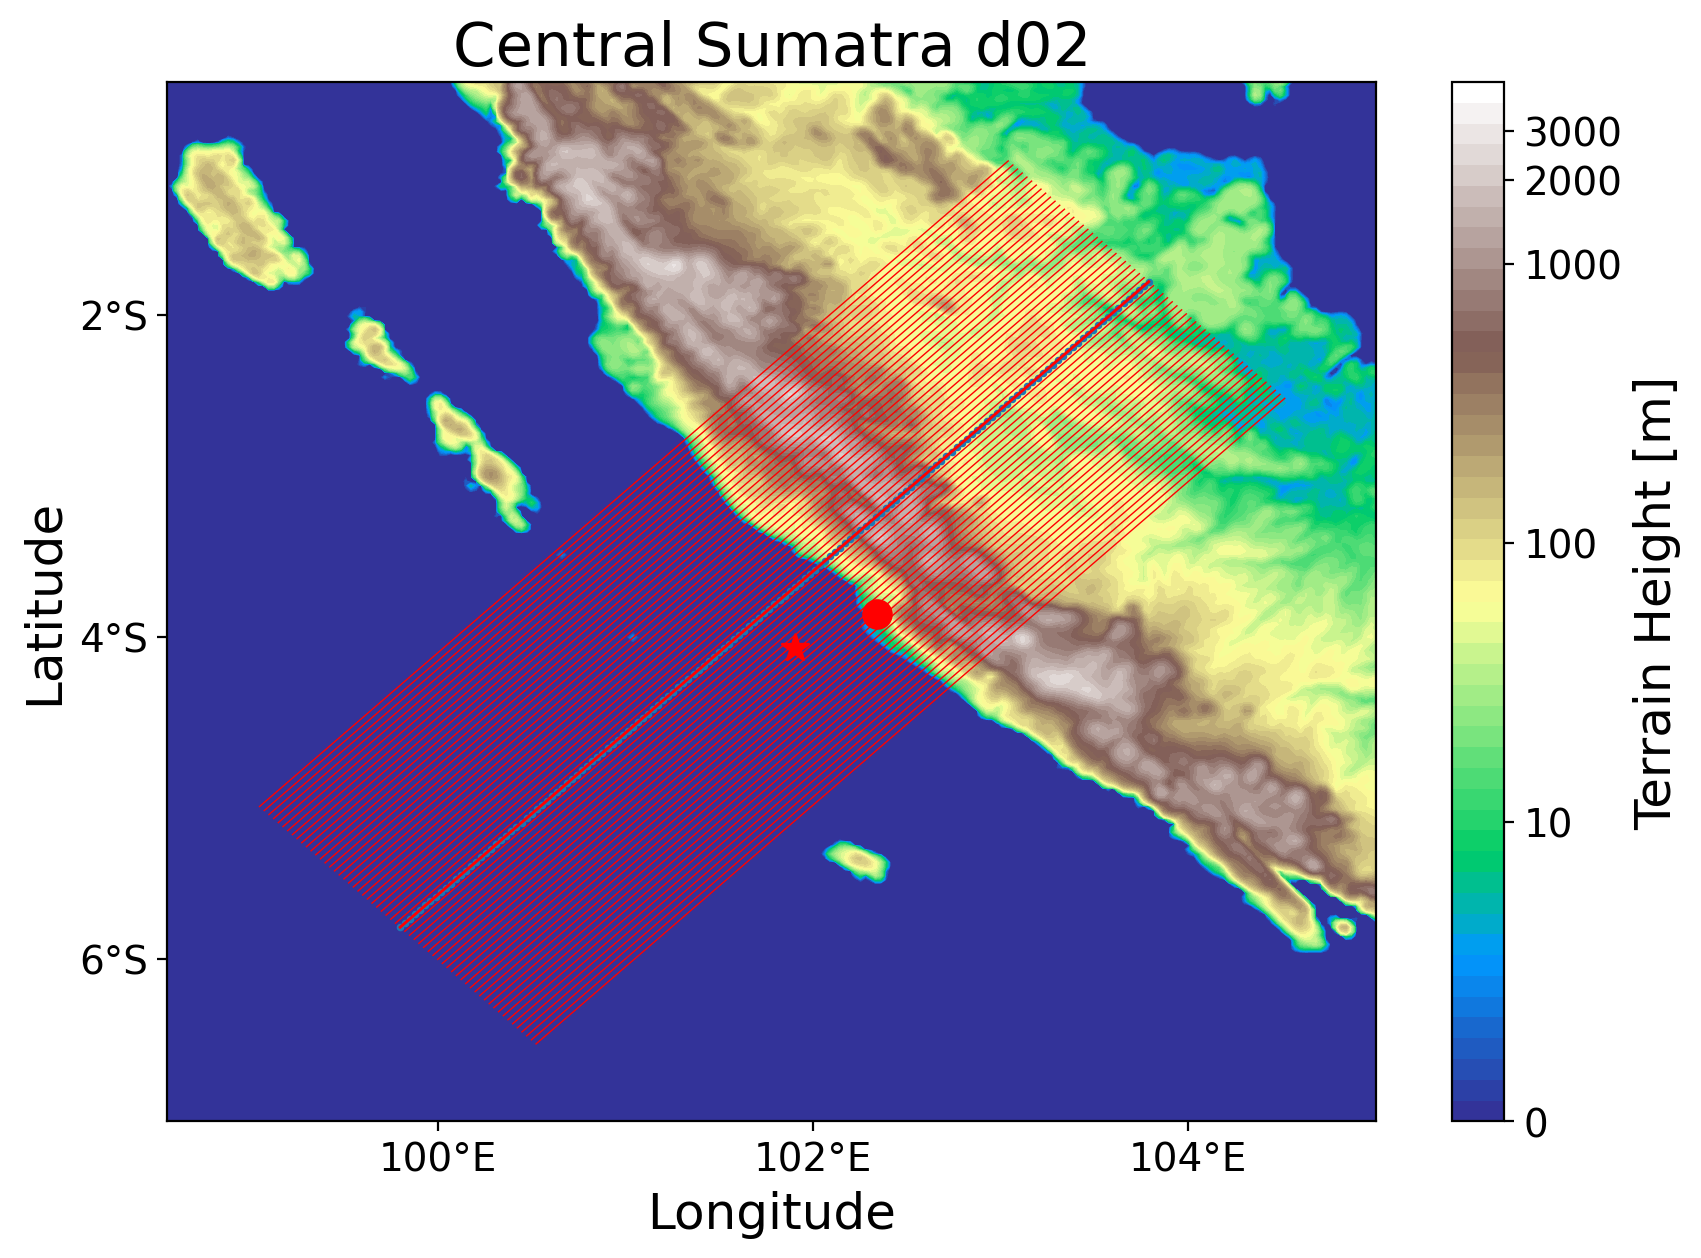

In [37]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

d02_coords = dict(
    south_north=('south_north',ds_d02.XLAT[0,:,0].values),
    west_east=('west_east',ds_d02.XLONG[0,0,:].values)
    )
# Prepare the Terrain Height    [m]
da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze()
x = da_d02_TOPO.assign_coords(d02_coords)
lat = [da_d02_cross_NormalWind_cntl.Lat.max()+0.5,da_d02_cross_NormalWind_cntl.Lat.min()-0.5]
lon = [da_d02_cross_NormalWind_cntl.Lon.min()-0.5,da_d02_cross_NormalWind_cntl.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[1],lat[0]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']

# Plot your terrain
ax1 = fig.add_subplot(gs[0,0])
cf1 = x.plot.contourf(
	cmap='terrain',
	# levels=np.arange(0,4250,250),
	levels = np.append(0,np.logspace(0,3.65,50)),

)

# Plot the individual cross-sectioned lines
for i in range(int(da_d02_cross_NormalWind_cntl.shape[3])):
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,i],da_d02_cross_NormalWind_cntl.Lat[:,i],'r',linewidth=0.5)
# Plot the center line
plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],'r',linewidth=1)
# Plot the grid resolution
plt.scatter(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],s=3)
# Plot the off-shore radar (R/V Mirai of JAMSTEC)
plt.scatter(101.90,-4.07,s=100,marker='*',c='r')
# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
plt.scatter(102.34,-3.86,s=100,marker='o',c='r')

cbar=cf1.colorbar
cbar.set_label('Terrain Height [m]',fontsize=18)
cbar.set_ticks([0,10,100,1000,2000,3000])
cbar.minorticks_off()
cbar.set_ticklabels([0,10,100,1000,2000,3000],fontsize=14)

ax1.set_xlabel('Longitude',fontsize=18)
ax1.set_ylabel('Latitude',fontsize=18)
ax1.set_title('Central Sumatra d02',fontsize=22)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_tick_labels,fontsize=14)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(y_tick_labels,fontsize=14)

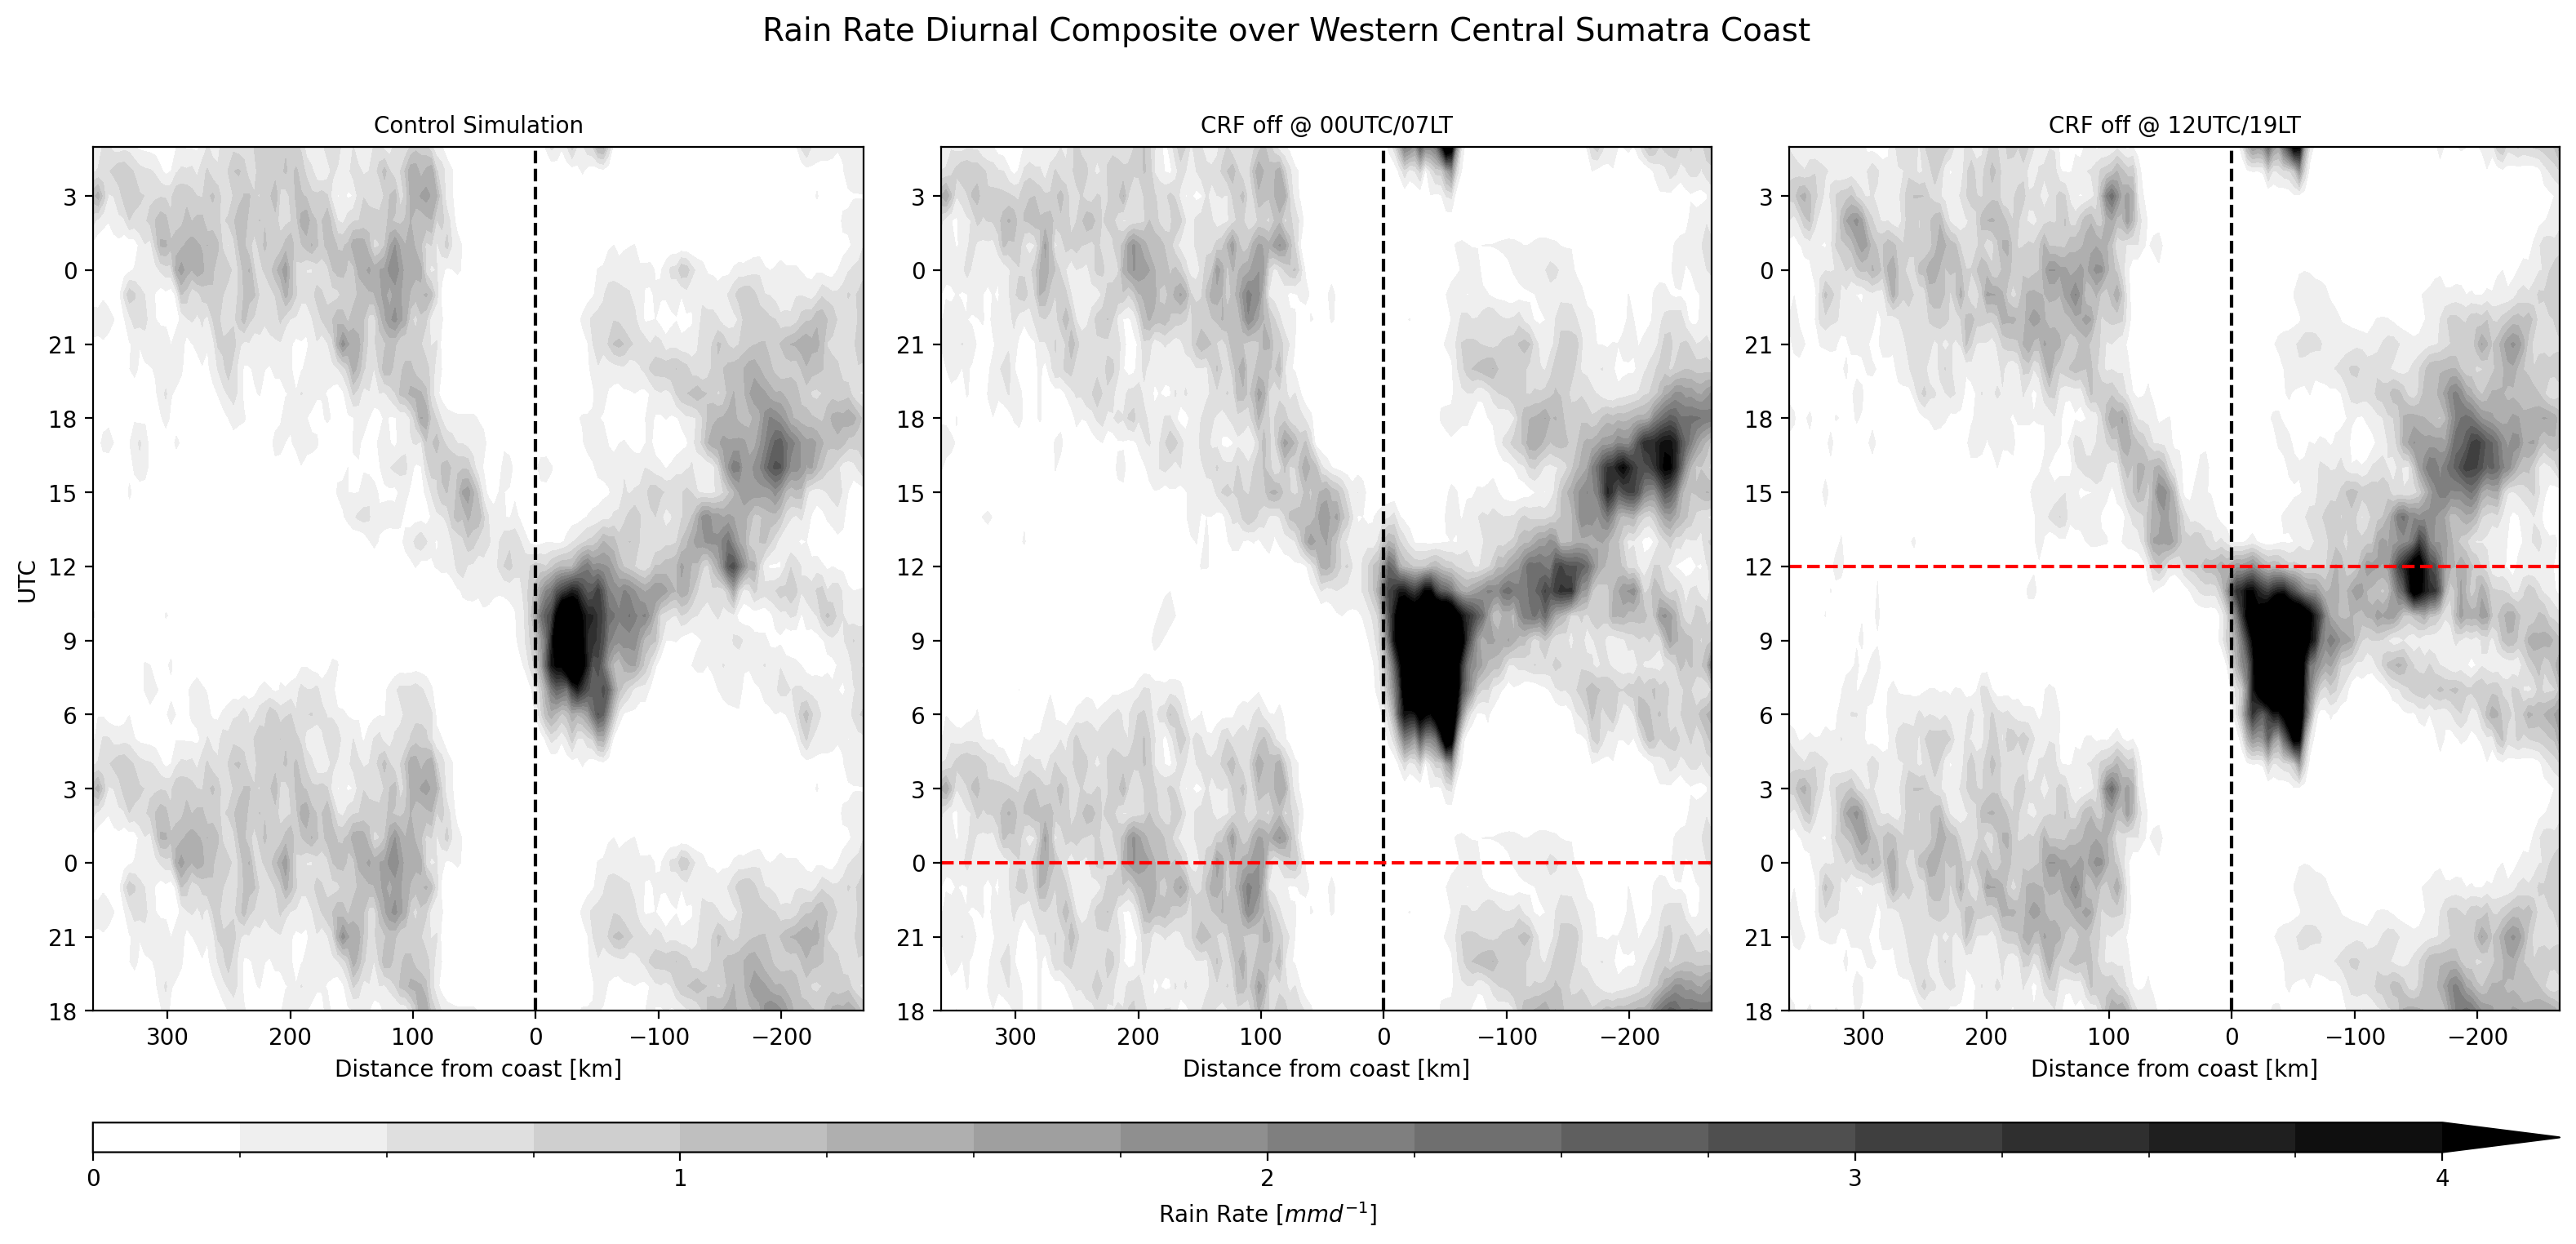

In [122]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Rain Rate Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

# Load Data
	# Control Data
x1 = da_d02_cross_RR_cntl
# # Switch to local time
# x1 = x1.assign_coords({'Time':x1.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x1.hour.values
x1 = x1.assign_coords(hour=(['hour'],np.arange(-6,30)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_RR_CRFoff.sel(Lead=slice(0,18,2))[1:25,...]		# Start from 1 instead of 0 because 0 is accumulated RR, and only go 24 hrs
# # Switch to local time
# x2 = x2.assign_coords({'Time':x2.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x2 = x2.groupby('EnsTime.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x2 = xr.concat([x2.isel(hour=slice(18,24)),x2,x2.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))


	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_RR_CRFoff.sel(Lead=slice(1,18,2))[1:25,...]
# # Switch to local time
# x3 = x3.assign_coords({'Time':x3.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x3 = x3.groupby('EnsTime.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x3 = xr.concat([x3.isel(hour=slice(18,24)),x3,x3.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x3.hour.values
x3 = x3.assign_coords(hour=(['hour'],np.arange(-6,30)))

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='gray_r',
	center=0
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='gray_r',
	center=0
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='gray_r',
	center=0
)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values)
ax2.set_yticks(x2.hour[0::3].values)
ax3.set_yticks(x3.hour[0::3].values)
ax1.set_yticklabels(yticks[0::3])
ax2.set_yticklabels(yticks[0::3])
ax3.set_yticklabels(yticks[0::3])
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,5,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]')


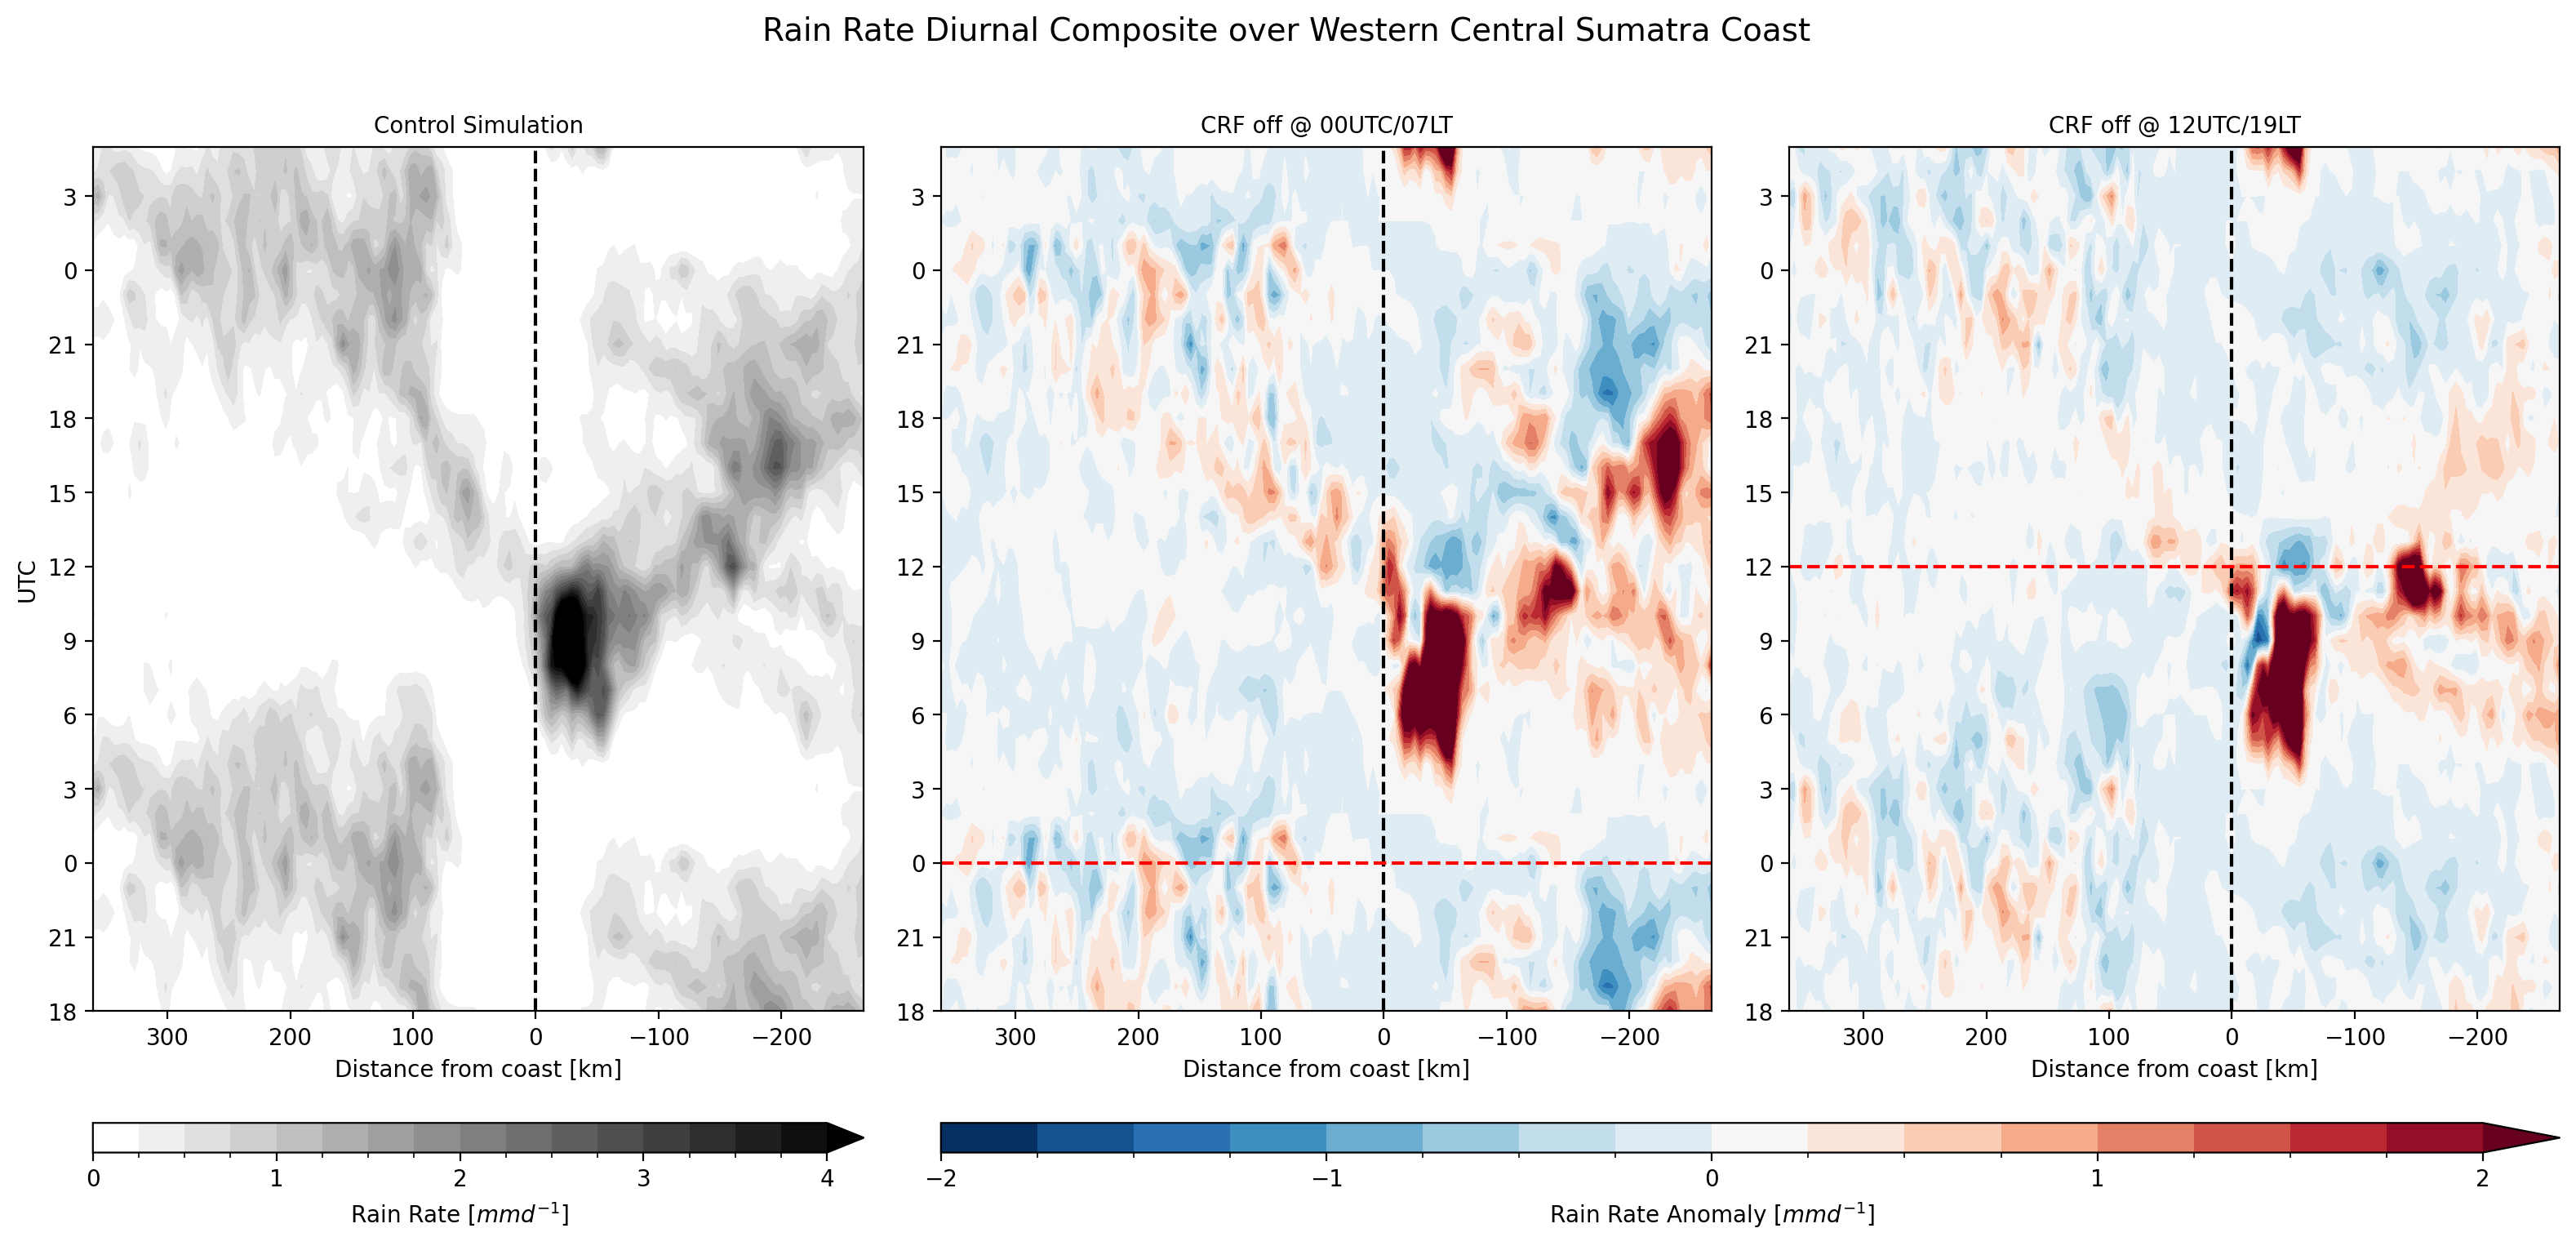

In [123]:
fig = plt.figure(figsize=(19.5,8))
gs = gridspec.GridSpec(nrows=2, ncols=3, hspace=0.25, height_ratios=[0.875,0.03], wspace=0.1, width_ratios=[.33,.33,.33])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
fig.suptitle('Rain Rate Diurnal Composite over Western Central Sumatra Coast', fontsize=14)

# Load Data
	# Control Data
x1 = da_d02_cross_RR_cntl
# # Switch to local time
# x1 = x1.assign_coords({'Time':x1.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x1 = x1.groupby('Time.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x1 = xr.concat([x1.isel(hour=slice(18,24)),x1,x1.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x1.hour.values
x1 = x1.assign_coords(hour=(['hour'],np.arange(-6,30)))

	# Sim data CRF off @ 00UTC	[Morning]
x2 = da_d02_cross_RR_CRFoff.sel(Lead=slice(0,18,2))[1:25,...]		# Start from 1 instead of 0 because 0 is accumulated RR, and only go 24 hrs
# # Switch to local time
# x2 = x2.assign_coords({'Time':x2.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x2 = x2.groupby('EnsTime.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x2 = xr.concat([x2.isel(hour=slice(18,24)),x2,x2.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x2.hour.values
x2 = x2.assign_coords(hour=(['hour'],np.arange(-6,30)))
# Anomaly
x2 = x2-x1


	# Sim data CRF off @ 12UTC	[Evening]
x3 = da_d02_cross_RR_CRFoff.sel(Lead=slice(1,18,2))[1:25,...]
# # Switch to local time
# x3 = x3.assign_coords({'Time':x3.Time + np.timedelta64(7,'h')})
# Composite diurnally, and then average over each cross-section
x3 = x3.groupby('EnsTime.hour').mean().mean('Spread')
# Concat to make a more continuous plot
x3 = xr.concat([x3.isel(hour=slice(18,24)),x3,x3.isel(hour=slice(0,6))],dim='hour',data_vars='all')
yticks = x3.hour.values
x3 = x3.assign_coords(hour=(['hour'],np.arange(-6,30)))
# Anomaly
x3 = x3-x1

# Plot the cross-sectional data
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(0,4.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='gray_r',
	center=0
)

# Plot the cross-sectional data
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-2,2.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='RdBu_r',
	center=0
)

# Plot the cross-sectional data
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'hour',
	add_colorbar=False,
	levels=np.arange(-2,2.25,0.25),
	# levels=np.append(0,np.logspace(0,0.75,20)),
	cmap='RdBu_r',
	center=0
)

# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=0, color='r', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax3.axhline(y=12, color='r', linestyle='--')
ax1.set_xlabel('Distance from coast [km]')
ax2.set_xlabel('Distance from coast [km]')
ax3.set_xlabel('Distance from coast [km]')
ax1.set_ylabel('UTC')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax1.set_yticks(x1.hour[0::3].values)
ax2.set_yticks(x2.hour[0::3].values)
ax3.set_yticks(x3.hour[0::3].values)
ax1.set_yticklabels(yticks[0::3])
ax2.set_yticklabels(yticks[0::3])
ax3.set_yticklabels(yticks[0::3])
# Set titles/labels
ax1.set_title('Control Simulation', loc='center', fontsize=10)
ax2.set_title('CRF off @ 00UTC/07LT', loc='center', fontsize=10)
ax3.set_title('CRF off @ 12UTC/19LT', loc='center', fontsize=10)
# ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
# ax1.set_title('', loc='center')

# Plot the colorbar
	# Rain rate colorbar
cax1 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,5,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]')
cax1 = fig.add_subplot(gs[1, 1:3])
cbar = plt.colorbar(cf2, cax=cax1, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-2,3,1))
cbar.set_label('Rain Rate Anomaly [$mm d^{-1}$]')


#### CRF Off versus control run comparisons

Rain Rate

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_RR_cross_cntl.mean('Spread')
# Data
	# Average over each cross-section
x2 = da_d02_RR_cross_CRFoff[...,0].mean('Spread')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = da_d02_RR_cross_CRFoff[3:,...,1].mean('Spread')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = da_d02_RR_cross_CRFoff[6:,...,2].mean('Spread')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = da_d02_RR_cross_CRFoff[9:,...,3].mean('Spread')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = da_d02_RR_cross_CRFoff[12:,...,4].mean('Spread')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6= xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Rain Rate Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Rain rate colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]', weight='bold')

Rain Rate Anomalies

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_RR_cross_cntl.mean('Spread')
# Data
	# Average over each cross-section
x2 = da_d02_RR_cross_CRFoff[...,0].mean('Spread')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x2 = x2-x1	# Calculate anomalies from Control
x3 = da_d02_RR_cross_CRFoff[3:,...,1].mean('Spread')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = x3-x1	# Calculate anomalies from Control
x4 = da_d02_RR_cross_CRFoff[6:,...,2].mean('Spread')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = x4-x1	# Calculate anomalies from Control
x5 = da_d02_RR_cross_CRFoff[9:,...,3].mean('Spread')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = x5-x1	# Calculate anomalies from Control
x6 = da_d02_RR_cross_CRFoff[12:,...,4].mean('Spread')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6= xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = x6-x1	# Calculate anomalies from Control

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,6.25,0.25),
	cmap='gray_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-2,2,0.25),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Rain Rate Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Rain Rate Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Control rain rate colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Rain Rate [$mm d^{-1}$]', weight='bold')
	# CRF Off rain rate colorbar
ax2 = fig.add_subplot(gs[1, 1:])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
cbar.set_ticks(np.arange(-2,3,1))
cbar.set_label('Rain Rate Anomlaies [$mm d^{-1}$]', weight='bold')

Normal Wind

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_cross_NormalWind_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_NormalWind_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = da_d02_NormalWind_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = da_d02_NormalWind_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = da_d02_NormalWind_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = da_d02_NormalWind_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Normal Wind Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Normal Wind colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Wind Speed [$m s^{-1}$]', weight='bold')

Normal Wind Anomalies

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_cross_NormalWind_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_NormalWind_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x2 = x2-x1	# Calculate anomalies from Control
x3 = da_d02_NormalWind_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = x3-x1	# Calculate anomalies from Control
x4 = da_d02_NormalWind_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = x4-x1	# Calculate anomalies from Control
x5 = da_d02_NormalWind_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = x5-x1	# Calculate anomalies from Control
x6 = da_d02_NormalWind_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = x6-x1	# Calculate anomalies from Control

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-6,7,1),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Normal Wind Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Normal Wind Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Normal Wind colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Wind Speed [$m s^{-1}$]', weight='bold')
	# CRF Off Normal Wind colorbar
ax2 = fig.add_subplot(gs[1, 1:])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Wind Speed Anomalies[$m s^{-1}$]', weight='bold')

Total Moisture Evolution

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_QTotal_cross_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_QTotal_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = da_d02_QTotal_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = da_d02_QTotal_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = da_d02_QTotal_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = da_d02_QTotal_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,.0255,.0005),
	cmap='Blues',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Total Moisture Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Total Moisture colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Total Moisture [$kg/kg$]', weight='bold')

Total Moisture Anomaly

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_QTotal_cross_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_QTotal_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x2 = x2-x1	# Calculate anomalies from Control
x3 = da_d02_QTotal_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = x3-x1	# Calculate anomalies from Control
x4 = da_d02_QTotal_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = x4-x1	# Calculate anomalies from Control
x5 = da_d02_QTotal_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = x5-x1	# Calculate anomalies from Control
x6 = da_d02_QTotal_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = x6-x1	# Calculate anomalies from Control

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(0,0.0255,0.0005),
	cmap='Blues',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-0.005,0.0055,0.0005),
	cmap='BrBG',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Total Moisture Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Total Moisture Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Total Moisture colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Total Moisture [$kg/kg$]', weight='bold')
	# CRF Off Total Moisture colorbar
ax2 = fig.add_subplot(gs[1, 1:])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Total Moisture Anomalies [$kg/kg$]', weight='bold')

Theta or Potential Temperature Evolution

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_Theta_cross_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_Theta_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = da_d02_Theta_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = da_d02_Theta_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = da_d02_Theta_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = da_d02_Theta_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Potential Temperature Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Potential Temperature Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Potential Temperature colorbar
ax2 = fig.add_subplot(gs[1, :])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Potential Temperature [$K$]', weight='bold')

Anomalous Potential Temperature Evolution

In [ ]:
fig = plt.figure(figsize=(56,10))
gs = gridspec.GridSpec(nrows=2, ncols=6, wspace=0.1, hspace=0.25, height_ratios=[0.875,0.03])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[0,3])
ax5 = fig.add_subplot(gs[0,4])
ax6 = fig.add_subplot(gs[0,5])

# Data
	# Average over each cross-section
x1 = da_d02_Theta_cross_cntl[:,:6,:,:].mean('Spread').mean('bottom_top')
# Data
	# Average over each cross-section
x2 = da_d02_Theta_cross_CRFoff[:,:6,:,:,0].mean('Spread').mean('bottom_top')	# starts at 11-25-03UTC
# This concats 11-25 00-04UTC with 11-25 05UTC to 11-26 12UTC
x2 = xr.concat([x1.isel(Time=slice(0,5)),x2[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x2 = x2-x1	# Calculate anomalies from Control
x3 = da_d02_Theta_cross_CRFoff[3:,:6,:,:,1].mean('Spread').mean('bottom_top')	# starts at 11-25-06UTC
# This concats 11-25 00-07UTC with 11-25 08UTC to 11-26 12UTC
x3 = xr.concat([x1.isel(Time=slice(0,8)),x3[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x3 = x3-x1	# Calculate anomalies from Control
x4 = da_d02_Theta_cross_CRFoff[6:,:6,:,:,2].mean('Spread').mean('bottom_top')	# starts at 11-25-09UTC
# This concats 11-25 00-10UTC with 11-25 11UTC to 11-26 12UTC
x4 = xr.concat([x1.isel(Time=slice(0,11)),x4[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x4 = x4-x1	# Calculate anomalies from Control
x5 = da_d02_Theta_cross_CRFoff[9:,:6,:,:,3].mean('Spread').mean('bottom_top')	# starts at 11-25-12UTC
# This concats 11-25 00-13UTC with 11-25 14UTC to 11-26 12UTC
x5 = xr.concat([x1.isel(Time=slice(0,14)),x5[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x5 = x5-x1	# Calculate anomalies from Control
x6 = da_d02_Theta_cross_CRFoff[12:,:6,:,:,4].mean('Spread').mean('bottom_top')	# starts at 11-25-15UTC
# This concats 11-25 00-16UTC with 11-25 17UTC to 11-26 12UTC
x6 = xr.concat([x1.isel(Time=slice(0,17)),x6[1:]],dim='Time',data_vars='all') # Must start at x2[1:] since the oth index is accumulated RR from start of cntl sim to the experiment point
x6 = x6-x1	# Calculate anomalies from Control

# Plot the cross-sectional data
	# Control
cf1 = x1.plot.contourf(
	ax=ax1,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(297,306,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 03 UTC
cf2 = x2.plot.contourf(
	ax=ax2,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 06 UTC
cf3 = x3.plot.contourf(
	ax=ax3,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 09 UTC
cf4 = x4.plot.contourf(
	ax=ax4,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 12 UTC
cf5 = x5.plot.contourf(
	ax=ax5,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
	# CRF off @ 15 UTC
cf6 = x6.plot.contourf(
	ax=ax6,
	x = 'Distance',
    y = 'Time',
	add_colorbar=False,
	levels=np.arange(-4,4,0.5),
	cmap='RdBu_r',
	center=0,
)
# Plot the vertical line at approximate coastline
ax1.axvline(x=0, color='k', linestyle='--')
ax2.axvline(x=0, color='k', linestyle='--')
ax3.axvline(x=0, color='k', linestyle='--')
ax4.axvline(x=0, color='k', linestyle='--')
ax5.axvline(x=0, color='k', linestyle='--')
ax6.axvline(x=0, color='k', linestyle='--')
ax2.axhline(y=x1.Time[3].values, color='r', linestyle='-')
ax3.axhline(y=x1.Time[6].values, color='r', linestyle='-')
ax4.axhline(y=x1.Time[9].values, color='r', linestyle='-')
ax5.axhline(y=x1.Time[12].values, color='r', linestyle='-')
ax6.axhline(y=x1.Time[15].values, color='r', linestyle='-')

ax1.set_xlabel('Distance from coast [km]', weight='bold')
ax2.set_xlabel('Distance from coast [km]', weight='bold')
ax3.set_xlabel('Distance from coast [km]', weight='bold')
ax4.set_xlabel('Distance from coast [km]', weight='bold')
ax5.set_xlabel('Distance from coast [km]', weight='bold')
ax6.set_xlabel('Distance from coast [km]', weight='bold')
ax1.set_ylabel('UTC', weight='bold')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax1.invert_xaxis()
ax2.invert_xaxis()
ax3.invert_xaxis()
ax4.invert_xaxis()
ax5.invert_xaxis()
ax6.invert_xaxis()
# ax1.set_yticks(x1.Time[0::12].values)
# ax1.set_yticklabels(x1.Time[0::12].dt.strftime("%m-%d %H").values)
ax1.set_yticks(x1.Time[::3].values)
ax2.set_yticks(x1.Time[::3].values)
ax3.set_yticks(x1.Time[::3].values)
ax4.set_yticks(x1.Time[::3].values)
ax5.set_yticks(x1.Time[::3].values)
ax6.set_yticks(x1.Time[::3].values)
ax1.set_yticklabels(x1.Time[::3].dt.strftime("%m-%d %H").values)
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
# Set titles/labels
ax1.set_title('Theta Evolution - d02 [CRF On]', loc='left', fontsize=10)
ax1.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax2.set_title('Theta Evolution - d02 [CRF Off @ 11-25 03]', loc='left', fontsize=10)
ax2.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax3.set_title('Theta Evolution - d02 [CRF Off @ 11-25 06]', loc='left', fontsize=10)
ax3.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax4.set_title('Theta Evolution - d02 [CRF Off @ 11-25 09]', loc='left', fontsize=10)
ax4.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax5.set_title('Theta Evolution - d02 [CRF Off @ 11-25 12]', loc='left', fontsize=10)
ax5.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax6.set_title('Theta Evolution - d02 [CRF Off @ 11-25 15]', loc='left', fontsize=10)
ax6.set_title('Western Central Coast of Sumatra', loc='right', fontsize=10)
ax1.set_title('', loc='center')
ax2.set_title('', loc='center')
ax3.set_title('', loc='center')
ax4.set_title('', loc='center')
ax5.set_title('', loc='center')
ax6.set_title('', loc='center')
# Create grids
ax1.grid(linestyle='--', axis='y', linewidth=1.5)
ax2.grid(linestyle='--', axis='y', linewidth=1.5)
ax3.grid(linestyle='--', axis='y', linewidth=1.5)
ax4.grid(linestyle='--', axis='y', linewidth=1.5)
ax5.grid(linestyle='--', axis='y', linewidth=1.5)
ax6.grid(linestyle='--', axis='y', linewidth=1.5)

# Plot the colorbar
	# Theta colorbar
ax2 = fig.add_subplot(gs[1, 0])
cbar = plt.colorbar(cf1, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Theta [$K$]', weight='bold')
	# CRF Off Theta colorbar
ax2 = fig.add_subplot(gs[1, 1:])
cbar = plt.colorbar(cf2, cax=ax2, orientation='horizontal', pad=0 , aspect=100)
# cbar.set_ticks(np.arange(0,7,1))
cbar.set_label('Theta Anomalies [$K$]', weight='bold')

#### Spatial Analysis

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

# Assign variable
x = da_d02_RR.sel(
	Time=slice(da_d02_RR.Time[60],da_d02_RR_cross_preconv.Time[-1])
)

# Set the lat lon bounds
lat = [da_d02_cross_NormalWind_cntl.Lat.max()+0.5,da_d02_cross_NormalWind_cntl.Lat.min()-0.5]
lon = [da_d02_cross_NormalWind_cntl.Lon.min()-0.5,da_d02_cross_NormalWind_cntl.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[1],lat[0]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']
# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(9.75,6.75))
	gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)
	ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
	ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

	cf1 = x[i].plot.contourf(
		ax=ax1,
		levels=np.arange(0,6.5,0.5),
		cmap='gray_r',
	)

	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,0],da_d02_cross_NormalWind_cntl.Lat[:,0],'r',linewidth=0.5)
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,-1],da_d02_cross_NormalWind_cntl.Lat[:,-1],'r',linewidth=0.5)
	# Plot the center line
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],'r',linewidth=1)
	# Plot the off-shore radar (R/V Mirai of JAMSTEC)
	plt.scatter(101.90,-4.07,s=100,marker='*',c='r')
	# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
	plt.scatter(102.34,-3.86,s=100,marker='o',c='r')

	cbar=cf1.colorbar
	cbar.set_label('Rain Rate [$mm d^{-1}$]',fontsize=16)
	ax1.set_xlabel('Longitude',fontsize=16)
	ax1.set_ylabel('Latitude',fontsize=16)
	# In UTC
	local_date = x.Time[i]
	string = 'Rain rate at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left')
	# ax1.set_title('Central Sumatra\nRain Rate Evolution',fontsize=22)
	ax1.set_xticks(x_ticks)
	ax1.set_xticklabels(x_tick_labels,fontsize=14)
	ax1.set_yticks(y_ticks)
	ax1.set_yticklabels(y_tick_labels,fontsize=14)

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Sumatra_RR_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
fig = plt.figure(figsize=(9.75,6.75))
gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)

# Assign variable
file = parent_dir +'/CRFoff/pre_conv_2015-11-25-03--11-26-12'+'/L1/d02_RR'				# [mm/dt]
ds = open_ds(file,time_ind_d02,lat_ind_d02,lon_ind_d02)
x = ds['RR'].compute()
d02_coords = dict(
    XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values[64:97,...]),
    XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values[64:97,...]),
    bottom_top=(('bottom_top'),interp_P_levels),
    Time=('Time',ds_d02.XTIME.values[64:97]),
    south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
    west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
    )
x = x.assign_coords(without_keys(d02_coords,'bottom_top'))
	# Average over each cross-section
y = da_d02_RR
x = xr.concat([y.isel(Time=slice(60,65)),x[1:]],dim='Time',data_vars='all')


# Set the lat lon bounds
lat = [da_d02_cross_NormalWind_cntl.Lat.max()+0.5,da_d02_cross_NormalWind_cntl.Lat.min()-0.5]
lon = [da_d02_cross_NormalWind_cntl.Lon.min()-0.5,da_d02_cross_NormalWind_cntl.Lon.max()+0.5]

# Yokoi et al. 2017-2019 domain:
x = x.sel(
	south_north=slice(lat[1],lat[0]),
	west_east=slice(lon[0],lon[1]))

x_ticks = np.array([100,102,104])
x_tick_labels = [u'100\N{DEGREE SIGN}E',
                 u'102\N{DEGREE SIGN}E', u'104\N{DEGREE SIGN}E']
y_ticks = np.array([-6,-4,-2])
y_tick_labels = [u'6\N{DEGREE SIGN}S',
                 u'4\N{DEGREE SIGN}S', u'2\N{DEGREE SIGN}S']
# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(9.75,6.75))
	gs = gridspec.GridSpec(nrows=1, ncols=1, hspace=0.075)
	ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
	ax1.coastlines(linewidth=1.5, color='k', resolution='50m')  # cartopy function

	cf1 = x[i].plot.contourf(
		ax=ax1,
		levels=np.arange(0,6.5,0.5),
		cmap='gray_r',
	)

	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,0],da_d02_cross_NormalWind_cntl.Lat[:,0],'r',linewidth=0.5)
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,-1],da_d02_cross_NormalWind_cntl.Lat[:,-1],'r',linewidth=0.5)
	# Plot the center line
	plt.plot(da_d02_cross_NormalWind_cntl.Lon[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],da_d02_cross_NormalWind_cntl.Lat[:,int(da_d02_cross_NormalWind_cntl.shape[3]/2)],'r',linewidth=1)
	# Plot the off-shore radar (R/V Mirai of JAMSTEC)
	plt.scatter(101.90,-4.07,s=100,marker='*',c='r')
	# Plot the on-shore observatory in Bengkulu city (BMKG observatory)
	plt.scatter(102.34,-3.86,s=100,marker='o',c='r')

	cbar=cf1.colorbar
	cbar.set_label('Rain Rate [$mm d^{-1}$]',fontsize=16)
	ax1.set_xlabel('Longitude',fontsize=16)
	ax1.set_ylabel('Latitude',fontsize=16)
	# In UTC
	local_date = x.Time[i]
	string = 'Rain rate at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ 11-25 03UTC', loc='left', fontsize=10)
	# ax1.set_title('Central Sumatra\nRain Rate Evolution',fontsize=22)
	ax1.set_xticks(x_ticks)
	ax1.set_xticklabels(x_tick_labels,fontsize=14)
	ax1.set_yticks(y_ticks)
	ax1.set_yticklabels(y_tick_labels,fontsize=14)

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Sumatra_RR_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

#### Cross-sectional Analysis

In [ ]:
# Data
x = da_d02_cross_NormalWind_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NormalWind_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_NormalWind_cross_preconv.mean('Spread')
y = da_d02_cross_NormalWind_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NormalWind_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_CLDFRA_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(0,0.525,0.025),
		levels=np.append(0,np.logspace(-2,0,25)),
		# vmax=0.5,
		cmap='Greys',
		yscale='log',
		# center=0,
		ylim=[100,1000],
		# alpha=0.4
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Cloud Fraction at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_label('Cloud Fraction')
	cbar.set_ticks([0,0.1,0.2,0.4,0.6,0.8,1])
	cbar.minorticks_off()
	cbar.set_ticklabels([0,0.1,0.2,0.4,0.6,0.8,1])

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_CLDFRA_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_CLDFRA_cross_preconv.mean('Spread')
y = da_d02_CLDFRA_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')

	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		# levels=np.arange(0,0.525,0.025),
		levels=np.append(0,np.logspace(-2,0,25)),
		# vmax=0.5,
		cmap='Greys',
		yscale='log',
		# center=0,
		ylim=[100,1000],
		# alpha=0.4
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Cloud Fraction at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	cbar.set_label('Cloud Fraction')
	cbar.set_ticks([0,0.1,0.2,0.4,0.6,0.8,1])
	cbar.minorticks_off()
	cbar.set_ticklabels([0,0.1,0.2,0.4,0.6,0.8,1])

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_CLDFRA_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_RH_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,100,5),
		extend='max',
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[100,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Relative Humidity at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Relative Humidity [%]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_RH_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data

x = da_d02_RH_cross_preconv.mean('Spread')
y = da_d02_RH_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')


for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,100,5),
		extend='max',
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[100,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Relative Humidity at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,100,10)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, extend='max')
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Relative Humidity [%]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_RH_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_QTotal_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.021,.0005),
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Total Moisture at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Total Moisture [$kg/kg$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_QTotal_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_QTotal_cross_preconv.mean('Spread')
y = da_d02_QTotal_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.021,.0005),
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Total Moisture at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Total Moisture [$kg/kg$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_QTotal_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_QI_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.00008,.000005),
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Ice Mixing Ratio at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Ice mixing ratio [$kg/kg$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_QIce_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_QI_cross_preconv.mean('Spread')
y = da_d02_QI_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

for i in range(x.shape[0]):
# for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(0,.000085,.000005),
		cmap='BrBG',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Ice Mixing Ratio at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Ice mixing ratio [$kg/kg$]')

	plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_QIce_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	mpl.pyplot.close()

In [ ]:
# Data
x = da_d02_NormalWind_cross_preconv.mean('Spread')
y = da_d02_cross_NormalWind_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NormalWind_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

#### Sanity Check

In [ ]:
# Data
	# Composite diurnally, and then average over each cross-section
x = da_d02_NetCRF_cross_preconv.mean('Spread')
y = da_d02_NetCRF_cross_cntl.mean('Spread')
x = xr.concat([y.isel(Time=slice(60,64)),x[:]],dim='Time',data_vars='all')

z = da_d02_RR_cross_preconv.mean('Spread')
y = da_d02_RR_cross_cntl.mean('Spread')
z = xr.concat([y.isel(Time=slice(60,65)),z[1:]],dim='Time',data_vars='all')

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-3*10**-5,3.25*10**-5,0.25*10**-5),
		extend='both',
		vmax=3*10**-5,
		vmin=-3*10**-5,
		# norm=MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0),
		cmap='RdBu_r',
		yscale='log',
		ylim=[100,1000],
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Net CRF at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF Off @ '+ str(x.Time[3].dt.strftime("%m-%d %H").to_numpy()) + 'UTC', loc='left', fontsize=8)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100, ticks=np.arange(-3*10**-5,4*10**-5,1*10**-5))
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Net CRF [$K s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NetCRF_preconv_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()

In [ ]:
# Calculate temperature
x = (1000/np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50))))**0.286
da_d02_Temp_cross_cntl = xr.DataArray.copy(da_d02_Theta_cross_cntl)
for i in range(len(x)):
	da_d02_Temp_cross_cntl[:,i,:,:] = da_d02_Theta_cross_cntl[:,i,:,:]/x[i]

In [ ]:
# Data
x = da_d02_Theta_cross_cntl.mean('Spread')[60:97]
z = da_d02_RR_cross_cntl.mean('Spread')[60:97]

# for i in range(x.shape[0]):
for i in range(1):
	fig = plt.figure(figsize=(6.5,4.5))
	gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.1, wspace= 0.1, height_ratios=[0.85,0.15], width_ratios=[.96,.04])
	ax1 = fig.add_subplot(gs[0,0])

	# Plot terrains
	y = np.max(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='blue',linewidth=1)
	y = np.min(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='red',linewidth=1)
	y = np.average(terrain_height_d02,axis=(0,2))
	plt.plot(x.Distance,y,color='black')
	# Plot the cross-sectional data
	cf1 = x[i,...].plot.contourf(
		ax=ax1,
		add_colorbar=False,
		levels=np.arange(-6,7,1),
		cmap='RdBu_r',
		yscale='log',
		center=0,
		ylim=[200,1000]
	)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax1.set_ylabel('Pressure Levels [hPa]')
	ax1.set_xlabel('')
	ax1.invert_yaxis()
	ax1.invert_xaxis()
	# In UTC
	local_date = x.Time[i]
	string = 'Normal Wind at ' + str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy()) + 'UTC'
	ax1.set_title('',loc='center')
	ax1.set_title(string,loc='right')
	ax1.set_title('CRF On', loc='left', fontsize=10)
	yticks = np.linspace(1000,200,9)
	ax1.set_yticks(yticks)
	ax1.set_xticks([])
	ax1.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

	# Plot the rain rates
	ax2 = fig.add_subplot(gs[1,0])
	l1 = z[i,...].plot(
		ax=ax2,
		xlim=[z.Distance[0],z.Distance[-1]],
		ylim=[0,4],
	)
	ax2.grid(linestyle='--', axis='y', linewidth=0.5)
	# Plot the vertical line at approximate coastline
	plt.axvline(x=0, color='k', linestyle='--')
	ax2.set_xlabel('Distance from coast [km]')
	ax2.set_ylabel('Rain Rate\n[$mm day^{-1}$]\n',fontsize=8)
	ax2.invert_xaxis()
	ax2.set_yticks([0,2,4])
	ax2.set_title('')
	# Plot the color bar
	ax3 = fig.add_subplot(gs[:, 1])
	cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	# cbar = plt.colorbar(cf1, cax=ax3, orientation='vertical', pad=0 , aspect=100)
	cbar.set_label('Wind Speed [$m s^{-1}$]')

	# plt.savefig('/home/hragnajarian/analysis/temp_plots/WRF_Cross_Sumatra_NormalWind_cntl_d02_'+str(local_date.dt.strftime("%Y-%m-%d %H").to_numpy())+'UTC.png',dpi=300)
	# mpl.pyplot.close()